# Convolutional Autoencoder

We will evaluate denoising autoencoders applied to the MNIST dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\geesi\Anaconda3\envs\dlnd\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Build Model 

Autoencoders can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. We wil use 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder.

In [7]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [8]:
sess = tf.Session()

In [9]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6963
Epoch: 1/100... Training loss: 0.6888
Epoch: 1/100... Training loss: 0.6817
Epoch: 1/100... Training loss: 0.6691
Epoch: 1/100... Training loss: 0.6500
Epoch: 1/100... Training loss: 0.6193
Epoch: 1/100... Training loss: 0.5831
Epoch: 1/100... Training loss: 0.5391
Epoch: 1/100... Training loss: 0.5141
Epoch: 1/100... Training loss: 0.4993
Epoch: 1/100... Training loss: 0.5381
Epoch: 1/100... Training loss: 0.5265
Epoch: 1/100... Training loss: 0.5055
Epoch: 1/100... Training loss: 0.4760
Epoch: 1/100... Training loss: 0.4790
Epoch: 1/100... Training loss: 0.4601
Epoch: 1/100... Training loss: 0.4676
Epoch: 1/100... Training loss: 0.4571
Epoch: 1/100... Training loss: 0.4501
Epoch: 1/100... Training loss: 0.4393
Epoch: 1/100... Training loss: 0.4213
Epoch: 1/100... Training loss: 0.4212
Epoch: 1/100... Training loss: 0.4179
Epoch: 1/100... Training loss: 0.4021
Epoch: 1/100... Training loss: 0.3889
Epoch: 1/100... Training loss: 0.3717
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1785
Epoch: 1/100... Training loss: 0.1754
Epoch: 1/100... Training loss: 0.1816
Epoch: 1/100... Training loss: 0.1784
Epoch: 1/100... Training loss: 0.1807
Epoch: 1/100... Training loss: 0.1693
Epoch: 1/100... Training loss: 0.1744
Epoch: 1/100... Training loss: 0.1791
Epoch: 1/100... Training loss: 0.1737
Epoch: 1/100... Training loss: 0.1771
Epoch: 1/100... Training loss: 0.1763
Epoch: 1/100... Training loss: 0.1742
Epoch: 1/100... Training loss: 0.1808
Epoch: 1/100... Training loss: 0.1711
Epoch: 1/100... Training loss: 0.1775
Epoch: 1/100... Training loss: 0.1765
Epoch: 1/100... Training loss: 0.1787
Epoch: 1/100... Training loss: 0.1769
Epoch: 1/100... Training loss: 0.1761
Epoch: 1/100... Training loss: 0.1771
Epoch: 1/100... Training loss: 0.1748
Epoch: 1/100... Training loss: 0.1785
Epoch: 1/100... Training loss: 0.1716
Epoch: 1/100... Training loss: 0.1741
Epoch: 1/100... Training loss: 0.1694
Epoch: 1/100... Training loss: 0.1721
Epoch: 1/100

Epoch: 2/100... Training loss: 0.1511
Epoch: 2/100... Training loss: 0.1496
Epoch: 2/100... Training loss: 0.1515
Epoch: 2/100... Training loss: 0.1534
Epoch: 2/100... Training loss: 0.1483
Epoch: 2/100... Training loss: 0.1485
Epoch: 2/100... Training loss: 0.1499
Epoch: 2/100... Training loss: 0.1557
Epoch: 2/100... Training loss: 0.1498
Epoch: 2/100... Training loss: 0.1554
Epoch: 2/100... Training loss: 0.1545
Epoch: 2/100... Training loss: 0.1457
Epoch: 2/100... Training loss: 0.1477
Epoch: 2/100... Training loss: 0.1478
Epoch: 2/100... Training loss: 0.1486
Epoch: 2/100... Training loss: 0.1478
Epoch: 2/100... Training loss: 0.1468
Epoch: 2/100... Training loss: 0.1493
Epoch: 2/100... Training loss: 0.1498
Epoch: 2/100... Training loss: 0.1560
Epoch: 2/100... Training loss: 0.1507
Epoch: 2/100... Training loss: 0.1467
Epoch: 2/100... Training loss: 0.1510
Epoch: 2/100... Training loss: 0.1475
Epoch: 2/100... Training loss: 0.1484
Epoch: 2/100... Training loss: 0.1479
Epoch: 2/100

Epoch: 3/100... Training loss: 0.1387
Epoch: 3/100... Training loss: 0.1399
Epoch: 3/100... Training loss: 0.1351
Epoch: 3/100... Training loss: 0.1372
Epoch: 3/100... Training loss: 0.1354
Epoch: 3/100... Training loss: 0.1400
Epoch: 3/100... Training loss: 0.1396
Epoch: 3/100... Training loss: 0.1380
Epoch: 3/100... Training loss: 0.1380
Epoch: 3/100... Training loss: 0.1352
Epoch: 3/100... Training loss: 0.1408
Epoch: 3/100... Training loss: 0.1423
Epoch: 3/100... Training loss: 0.1382
Epoch: 3/100... Training loss: 0.1379
Epoch: 3/100... Training loss: 0.1431
Epoch: 3/100... Training loss: 0.1387
Epoch: 3/100... Training loss: 0.1392
Epoch: 3/100... Training loss: 0.1389
Epoch: 3/100... Training loss: 0.1402
Epoch: 3/100... Training loss: 0.1385
Epoch: 3/100... Training loss: 0.1406
Epoch: 3/100... Training loss: 0.1413
Epoch: 3/100... Training loss: 0.1352
Epoch: 3/100... Training loss: 0.1334
Epoch: 3/100... Training loss: 0.1392
Epoch: 3/100... Training loss: 0.1391
Epoch: 3/100

Epoch: 3/100... Training loss: 0.1316
Epoch: 3/100... Training loss: 0.1321
Epoch: 3/100... Training loss: 0.1311
Epoch: 3/100... Training loss: 0.1329
Epoch: 3/100... Training loss: 0.1332
Epoch: 3/100... Training loss: 0.1344
Epoch: 3/100... Training loss: 0.1329
Epoch: 3/100... Training loss: 0.1305
Epoch: 3/100... Training loss: 0.1369
Epoch: 3/100... Training loss: 0.1366
Epoch: 3/100... Training loss: 0.1334
Epoch: 3/100... Training loss: 0.1306
Epoch: 3/100... Training loss: 0.1307
Epoch: 3/100... Training loss: 0.1345
Epoch: 3/100... Training loss: 0.1304
Epoch: 3/100... Training loss: 0.1325
Epoch: 3/100... Training loss: 0.1349
Epoch: 3/100... Training loss: 0.1318
Epoch: 3/100... Training loss: 0.1328
Epoch: 3/100... Training loss: 0.1332
Epoch: 3/100... Training loss: 0.1331
Epoch: 3/100... Training loss: 0.1318
Epoch: 3/100... Training loss: 0.1296
Epoch: 4/100... Training loss: 0.1347
Epoch: 4/100... Training loss: 0.1333
Epoch: 4/100... Training loss: 0.1315
Epoch: 4/100

Epoch: 4/100... Training loss: 0.1257
Epoch: 4/100... Training loss: 0.1256
Epoch: 4/100... Training loss: 0.1300
Epoch: 4/100... Training loss: 0.1292
Epoch: 4/100... Training loss: 0.1321
Epoch: 4/100... Training loss: 0.1245
Epoch: 4/100... Training loss: 0.1325
Epoch: 4/100... Training loss: 0.1232
Epoch: 4/100... Training loss: 0.1342
Epoch: 4/100... Training loss: 0.1300
Epoch: 4/100... Training loss: 0.1227
Epoch: 4/100... Training loss: 0.1242
Epoch: 4/100... Training loss: 0.1294
Epoch: 4/100... Training loss: 0.1297
Epoch: 4/100... Training loss: 0.1302
Epoch: 4/100... Training loss: 0.1254
Epoch: 4/100... Training loss: 0.1251
Epoch: 4/100... Training loss: 0.1333
Epoch: 4/100... Training loss: 0.1306
Epoch: 4/100... Training loss: 0.1255
Epoch: 4/100... Training loss: 0.1256
Epoch: 4/100... Training loss: 0.1282
Epoch: 4/100... Training loss: 0.1295
Epoch: 4/100... Training loss: 0.1279
Epoch: 4/100... Training loss: 0.1279
Epoch: 4/100... Training loss: 0.1330
Epoch: 4/100

Epoch: 5/100... Training loss: 0.1279
Epoch: 5/100... Training loss: 0.1269
Epoch: 5/100... Training loss: 0.1276
Epoch: 5/100... Training loss: 0.1234
Epoch: 5/100... Training loss: 0.1247
Epoch: 5/100... Training loss: 0.1278
Epoch: 5/100... Training loss: 0.1262
Epoch: 5/100... Training loss: 0.1223
Epoch: 5/100... Training loss: 0.1244
Epoch: 5/100... Training loss: 0.1209
Epoch: 5/100... Training loss: 0.1263
Epoch: 5/100... Training loss: 0.1290
Epoch: 5/100... Training loss: 0.1247
Epoch: 5/100... Training loss: 0.1250
Epoch: 5/100... Training loss: 0.1273
Epoch: 5/100... Training loss: 0.1255
Epoch: 5/100... Training loss: 0.1248
Epoch: 5/100... Training loss: 0.1265
Epoch: 5/100... Training loss: 0.1194
Epoch: 5/100... Training loss: 0.1266
Epoch: 5/100... Training loss: 0.1315
Epoch: 5/100... Training loss: 0.1251
Epoch: 5/100... Training loss: 0.1283
Epoch: 5/100... Training loss: 0.1250
Epoch: 5/100... Training loss: 0.1214
Epoch: 5/100... Training loss: 0.1255
Epoch: 5/100

Epoch: 6/100... Training loss: 0.1211
Epoch: 6/100... Training loss: 0.1185
Epoch: 6/100... Training loss: 0.1242
Epoch: 6/100... Training loss: 0.1279
Epoch: 6/100... Training loss: 0.1255
Epoch: 6/100... Training loss: 0.1219
Epoch: 6/100... Training loss: 0.1215
Epoch: 6/100... Training loss: 0.1226
Epoch: 6/100... Training loss: 0.1182
Epoch: 6/100... Training loss: 0.1248
Epoch: 6/100... Training loss: 0.1230
Epoch: 6/100... Training loss: 0.1262
Epoch: 6/100... Training loss: 0.1223
Epoch: 6/100... Training loss: 0.1223
Epoch: 6/100... Training loss: 0.1243
Epoch: 6/100... Training loss: 0.1215
Epoch: 6/100... Training loss: 0.1247
Epoch: 6/100... Training loss: 0.1241
Epoch: 6/100... Training loss: 0.1220
Epoch: 6/100... Training loss: 0.1229
Epoch: 6/100... Training loss: 0.1229
Epoch: 6/100... Training loss: 0.1254
Epoch: 6/100... Training loss: 0.1211
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100... Training loss: 0.1201
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100

Epoch: 6/100... Training loss: 0.1188
Epoch: 6/100... Training loss: 0.1211
Epoch: 6/100... Training loss: 0.1227
Epoch: 6/100... Training loss: 0.1210
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100... Training loss: 0.1187
Epoch: 6/100... Training loss: 0.1224
Epoch: 6/100... Training loss: 0.1177
Epoch: 6/100... Training loss: 0.1240
Epoch: 6/100... Training loss: 0.1227
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100... Training loss: 0.1186
Epoch: 6/100... Training loss: 0.1211
Epoch: 6/100... Training loss: 0.1242
Epoch: 6/100... Training loss: 0.1170
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100... Training loss: 0.1191
Epoch: 6/100... Training loss: 0.1169
Epoch: 6/100... Training loss: 0.1188
Epoch: 6/100... Training loss: 0.1196
Epoch: 6/100... Training loss: 0.1190
Epoch: 6/100... Training loss: 0.1189
Epoch: 6/100... Training loss: 0.1185
Epoch: 6/100... Training loss: 0.1195
Epoch: 6/100... Training loss: 0.1234
Epoch: 6/100... Training loss: 0.1191
Epoch: 6/100

Epoch: 7/100... Training loss: 0.1210
Epoch: 7/100... Training loss: 0.1203
Epoch: 7/100... Training loss: 0.1185
Epoch: 7/100... Training loss: 0.1179
Epoch: 7/100... Training loss: 0.1187
Epoch: 7/100... Training loss: 0.1187
Epoch: 7/100... Training loss: 0.1196
Epoch: 7/100... Training loss: 0.1209
Epoch: 7/100... Training loss: 0.1184
Epoch: 7/100... Training loss: 0.1177
Epoch: 7/100... Training loss: 0.1187
Epoch: 7/100... Training loss: 0.1202
Epoch: 7/100... Training loss: 0.1205
Epoch: 7/100... Training loss: 0.1189
Epoch: 7/100... Training loss: 0.1182
Epoch: 7/100... Training loss: 0.1215
Epoch: 7/100... Training loss: 0.1182
Epoch: 7/100... Training loss: 0.1204
Epoch: 7/100... Training loss: 0.1174
Epoch: 7/100... Training loss: 0.1190
Epoch: 7/100... Training loss: 0.1216
Epoch: 7/100... Training loss: 0.1193
Epoch: 7/100... Training loss: 0.1173
Epoch: 7/100... Training loss: 0.1168
Epoch: 7/100... Training loss: 0.1208
Epoch: 7/100... Training loss: 0.1152
Epoch: 7/100

Epoch: 8/100... Training loss: 0.1197
Epoch: 8/100... Training loss: 0.1176
Epoch: 8/100... Training loss: 0.1210
Epoch: 8/100... Training loss: 0.1150
Epoch: 8/100... Training loss: 0.1216
Epoch: 8/100... Training loss: 0.1167
Epoch: 8/100... Training loss: 0.1191
Epoch: 8/100... Training loss: 0.1173
Epoch: 8/100... Training loss: 0.1182
Epoch: 8/100... Training loss: 0.1212
Epoch: 8/100... Training loss: 0.1139
Epoch: 8/100... Training loss: 0.1202
Epoch: 8/100... Training loss: 0.1224
Epoch: 8/100... Training loss: 0.1192
Epoch: 8/100... Training loss: 0.1171
Epoch: 8/100... Training loss: 0.1195
Epoch: 8/100... Training loss: 0.1174
Epoch: 8/100... Training loss: 0.1158
Epoch: 8/100... Training loss: 0.1176
Epoch: 8/100... Training loss: 0.1228
Epoch: 8/100... Training loss: 0.1199
Epoch: 8/100... Training loss: 0.1191
Epoch: 8/100... Training loss: 0.1215
Epoch: 8/100... Training loss: 0.1181
Epoch: 8/100... Training loss: 0.1139
Epoch: 8/100... Training loss: 0.1153
Epoch: 8/100

Epoch: 9/100... Training loss: 0.1202
Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1143
Epoch: 9/100... Training loss: 0.1172
Epoch: 9/100... Training loss: 0.1168
Epoch: 9/100... Training loss: 0.1180
Epoch: 9/100... Training loss: 0.1179
Epoch: 9/100... Training loss: 0.1188
Epoch: 9/100... Training loss: 0.1135
Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1137
Epoch: 9/100... Training loss: 0.1157
Epoch: 9/100... Training loss: 0.1166
Epoch: 9/100... Training loss: 0.1189
Epoch: 9/100... Training loss: 0.1173
Epoch: 9/100... Training loss: 0.1124
Epoch: 9/100... Training loss: 0.1117
Epoch: 9/100... Training loss: 0.1163
Epoch: 9/100... Training loss: 0.1195
Epoch: 9/100... Training loss: 0.1192
Epoch: 9/100... Training loss: 0.1195
Epoch: 9/100... Training loss: 0.1169
Epoch: 9/100... Training loss: 0.1139
Epoch: 9/100... Training loss: 0.1172
Epoch: 9/100... Training loss: 0.1157
Epoch: 9/100... Training loss: 0.1199
Epoch: 9/100

Epoch: 9/100... Training loss: 0.1153
Epoch: 9/100... Training loss: 0.1206
Epoch: 9/100... Training loss: 0.1135
Epoch: 9/100... Training loss: 0.1166
Epoch: 9/100... Training loss: 0.1166
Epoch: 9/100... Training loss: 0.1159
Epoch: 9/100... Training loss: 0.1139
Epoch: 9/100... Training loss: 0.1163
Epoch: 9/100... Training loss: 0.1183
Epoch: 9/100... Training loss: 0.1172
Epoch: 9/100... Training loss: 0.1185
Epoch: 9/100... Training loss: 0.1170
Epoch: 9/100... Training loss: 0.1165
Epoch: 9/100... Training loss: 0.1187
Epoch: 9/100... Training loss: 0.1117
Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1156
Epoch: 9/100... Training loss: 0.1169
Epoch: 9/100... Training loss: 0.1166
Epoch: 9/100... Training loss: 0.1159
Epoch: 9/100... Training loss: 0.1178
Epoch: 9/100... Training loss: 0.1145
Epoch: 9/100... Training loss: 0.1148
Epoch: 9/100... Training loss: 0.1180
Epoch: 9/100... Training loss: 0.1140
Epoch: 9/100... Training loss: 0.1149
Epoch: 9/100

Epoch: 10/100... Training loss: 0.1182
Epoch: 10/100... Training loss: 0.1168
Epoch: 10/100... Training loss: 0.1102
Epoch: 10/100... Training loss: 0.1102
Epoch: 10/100... Training loss: 0.1120
Epoch: 10/100... Training loss: 0.1142
Epoch: 10/100... Training loss: 0.1154
Epoch: 10/100... Training loss: 0.1161
Epoch: 10/100... Training loss: 0.1110
Epoch: 10/100... Training loss: 0.1141
Epoch: 10/100... Training loss: 0.1140
Epoch: 10/100... Training loss: 0.1138
Epoch: 10/100... Training loss: 0.1125
Epoch: 10/100... Training loss: 0.1156
Epoch: 10/100... Training loss: 0.1156
Epoch: 10/100... Training loss: 0.1126
Epoch: 10/100... Training loss: 0.1131
Epoch: 10/100... Training loss: 0.1162
Epoch: 10/100... Training loss: 0.1117
Epoch: 10/100... Training loss: 0.1195
Epoch: 10/100... Training loss: 0.1144
Epoch: 10/100... Training loss: 0.1170
Epoch: 10/100... Training loss: 0.1166
Epoch: 10/100... Training loss: 0.1141
Epoch: 10/100... Training loss: 0.1130
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.1144
Epoch: 11/100... Training loss: 0.1158
Epoch: 11/100... Training loss: 0.1150
Epoch: 11/100... Training loss: 0.1117
Epoch: 11/100... Training loss: 0.1111
Epoch: 11/100... Training loss: 0.1107
Epoch: 11/100... Training loss: 0.1142
Epoch: 11/100... Training loss: 0.1153
Epoch: 11/100... Training loss: 0.1147
Epoch: 11/100... Training loss: 0.1129
Epoch: 11/100... Training loss: 0.1114
Epoch: 11/100... Training loss: 0.1149
Epoch: 11/100... Training loss: 0.1146
Epoch: 11/100... Training loss: 0.1142
Epoch: 11/100... Training loss: 0.1116
Epoch: 11/100... Training loss: 0.1132
Epoch: 11/100... Training loss: 0.1165
Epoch: 11/100... Training loss: 0.1140
Epoch: 11/100... Training loss: 0.1127
Epoch: 11/100... Training loss: 0.1171
Epoch: 11/100... Training loss: 0.1125
Epoch: 11/100... Training loss: 0.1156
Epoch: 11/100... Training loss: 0.1136
Epoch: 11/100... Training loss: 0.1136
Epoch: 11/100... Training loss: 0.1161
Epoch: 11/100... Training

Epoch: 11/100... Training loss: 0.1109
Epoch: 11/100... Training loss: 0.1152
Epoch: 11/100... Training loss: 0.1073
Epoch: 11/100... Training loss: 0.1111
Epoch: 11/100... Training loss: 0.1163
Epoch: 11/100... Training loss: 0.1111
Epoch: 11/100... Training loss: 0.1136
Epoch: 11/100... Training loss: 0.1103
Epoch: 11/100... Training loss: 0.1135
Epoch: 11/100... Training loss: 0.1056
Epoch: 11/100... Training loss: 0.1172
Epoch: 12/100... Training loss: 0.1152
Epoch: 12/100... Training loss: 0.1135
Epoch: 12/100... Training loss: 0.1102
Epoch: 12/100... Training loss: 0.1108
Epoch: 12/100... Training loss: 0.1139
Epoch: 12/100... Training loss: 0.1126
Epoch: 12/100... Training loss: 0.1147
Epoch: 12/100... Training loss: 0.1146
Epoch: 12/100... Training loss: 0.1114
Epoch: 12/100... Training loss: 0.1181
Epoch: 12/100... Training loss: 0.1151
Epoch: 12/100... Training loss: 0.1089
Epoch: 12/100... Training loss: 0.1153
Epoch: 12/100... Training loss: 0.1125
Epoch: 12/100... Training

Epoch: 12/100... Training loss: 0.1126
Epoch: 12/100... Training loss: 0.1113
Epoch: 12/100... Training loss: 0.1072
Epoch: 12/100... Training loss: 0.1137
Epoch: 12/100... Training loss: 0.1137
Epoch: 12/100... Training loss: 0.1144
Epoch: 12/100... Training loss: 0.1117
Epoch: 12/100... Training loss: 0.1108
Epoch: 12/100... Training loss: 0.1126
Epoch: 12/100... Training loss: 0.1126
Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1132
Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1112
Epoch: 12/100... Training loss: 0.1109
Epoch: 12/100... Training loss: 0.1144
Epoch: 12/100... Training loss: 0.1106
Epoch: 12/100... Training loss: 0.1118
Epoch: 12/100... Training loss: 0.1108
Epoch: 12/100... Training loss: 0.1116
Epoch: 12/100... Training loss: 0.1122
Epoch: 12/100... Training loss: 0.1123
Epoch: 12/100... Training loss: 0.1117
Epoch: 12/100... Training loss: 0.1159
Epoch: 12/100... Training loss: 0.1118
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.1101
Epoch: 13/100... Training loss: 0.1157
Epoch: 13/100... Training loss: 0.1130
Epoch: 13/100... Training loss: 0.1075
Epoch: 13/100... Training loss: 0.1115
Epoch: 13/100... Training loss: 0.1122
Epoch: 13/100... Training loss: 0.1103
Epoch: 13/100... Training loss: 0.1125
Epoch: 13/100... Training loss: 0.1098
Epoch: 13/100... Training loss: 0.1123
Epoch: 13/100... Training loss: 0.1094
Epoch: 13/100... Training loss: 0.1112
Epoch: 13/100... Training loss: 0.1122
Epoch: 13/100... Training loss: 0.1063
Epoch: 13/100... Training loss: 0.1127
Epoch: 13/100... Training loss: 0.1088
Epoch: 13/100... Training loss: 0.1093
Epoch: 13/100... Training loss: 0.1088
Epoch: 13/100... Training loss: 0.1125
Epoch: 13/100... Training loss: 0.1116
Epoch: 13/100... Training loss: 0.1120
Epoch: 13/100... Training loss: 0.1085
Epoch: 13/100... Training loss: 0.1107
Epoch: 13/100... Training loss: 0.1137
Epoch: 13/100... Training loss: 0.1107
Epoch: 13/100... Training

Epoch: 14/100... Training loss: 0.1124
Epoch: 14/100... Training loss: 0.1102
Epoch: 14/100... Training loss: 0.1143
Epoch: 14/100... Training loss: 0.1119
Epoch: 14/100... Training loss: 0.1086
Epoch: 14/100... Training loss: 0.1069
Epoch: 14/100... Training loss: 0.1106
Epoch: 14/100... Training loss: 0.1100
Epoch: 14/100... Training loss: 0.1084
Epoch: 14/100... Training loss: 0.1160
Epoch: 14/100... Training loss: 0.1080
Epoch: 14/100... Training loss: 0.1108
Epoch: 14/100... Training loss: 0.1135
Epoch: 14/100... Training loss: 0.1098
Epoch: 14/100... Training loss: 0.1091
Epoch: 14/100... Training loss: 0.1102
Epoch: 14/100... Training loss: 0.1098
Epoch: 14/100... Training loss: 0.1149
Epoch: 14/100... Training loss: 0.1117
Epoch: 14/100... Training loss: 0.1131
Epoch: 14/100... Training loss: 0.1118
Epoch: 14/100... Training loss: 0.1117
Epoch: 14/100... Training loss: 0.1141
Epoch: 14/100... Training loss: 0.1115
Epoch: 14/100... Training loss: 0.1095
Epoch: 14/100... Training

Epoch: 14/100... Training loss: 0.1104
Epoch: 14/100... Training loss: 0.1069
Epoch: 14/100... Training loss: 0.1090
Epoch: 14/100... Training loss: 0.1054
Epoch: 14/100... Training loss: 0.1087
Epoch: 14/100... Training loss: 0.1122
Epoch: 14/100... Training loss: 0.1118
Epoch: 14/100... Training loss: 0.1116
Epoch: 14/100... Training loss: 0.1081
Epoch: 14/100... Training loss: 0.1060
Epoch: 14/100... Training loss: 0.1112
Epoch: 14/100... Training loss: 0.1113
Epoch: 14/100... Training loss: 0.1099
Epoch: 14/100... Training loss: 0.1071
Epoch: 14/100... Training loss: 0.1107
Epoch: 14/100... Training loss: 0.1115
Epoch: 14/100... Training loss: 0.1109
Epoch: 14/100... Training loss: 0.1089
Epoch: 14/100... Training loss: 0.1092
Epoch: 14/100... Training loss: 0.1147
Epoch: 14/100... Training loss: 0.1080
Epoch: 14/100... Training loss: 0.1130
Epoch: 14/100... Training loss: 0.1095
Epoch: 14/100... Training loss: 0.1113
Epoch: 14/100... Training loss: 0.1123
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.1097
Epoch: 15/100... Training loss: 0.1097
Epoch: 15/100... Training loss: 0.1089
Epoch: 15/100... Training loss: 0.1097
Epoch: 15/100... Training loss: 0.1079
Epoch: 15/100... Training loss: 0.1107
Epoch: 15/100... Training loss: 0.1097
Epoch: 15/100... Training loss: 0.1100
Epoch: 15/100... Training loss: 0.1049
Epoch: 15/100... Training loss: 0.1054
Epoch: 15/100... Training loss: 0.1074
Epoch: 15/100... Training loss: 0.1092
Epoch: 15/100... Training loss: 0.1076
Epoch: 15/100... Training loss: 0.1088
Epoch: 15/100... Training loss: 0.1105
Epoch: 15/100... Training loss: 0.1111
Epoch: 15/100... Training loss: 0.1111
Epoch: 15/100... Training loss: 0.1100
Epoch: 15/100... Training loss: 0.1080
Epoch: 15/100... Training loss: 0.1085
Epoch: 15/100... Training loss: 0.1056
Epoch: 15/100... Training loss: 0.1127
Epoch: 15/100... Training loss: 0.1107
Epoch: 15/100... Training loss: 0.1107
Epoch: 15/100... Training loss: 0.1106
Epoch: 15/100... Training

Epoch: 16/100... Training loss: 0.1098
Epoch: 16/100... Training loss: 0.1117
Epoch: 16/100... Training loss: 0.1076
Epoch: 16/100... Training loss: 0.1109
Epoch: 16/100... Training loss: 0.1074
Epoch: 16/100... Training loss: 0.1094
Epoch: 16/100... Training loss: 0.1080
Epoch: 16/100... Training loss: 0.1100
Epoch: 16/100... Training loss: 0.1081
Epoch: 16/100... Training loss: 0.1053
Epoch: 16/100... Training loss: 0.1111
Epoch: 16/100... Training loss: 0.1090
Epoch: 16/100... Training loss: 0.1083
Epoch: 16/100... Training loss: 0.1060
Epoch: 16/100... Training loss: 0.1073
Epoch: 16/100... Training loss: 0.1089
Epoch: 16/100... Training loss: 0.1109
Epoch: 16/100... Training loss: 0.1124
Epoch: 16/100... Training loss: 0.1103
Epoch: 16/100... Training loss: 0.1095
Epoch: 16/100... Training loss: 0.1086
Epoch: 16/100... Training loss: 0.1165
Epoch: 16/100... Training loss: 0.1114
Epoch: 16/100... Training loss: 0.1114
Epoch: 16/100... Training loss: 0.1100
Epoch: 16/100... Training

Epoch: 17/100... Training loss: 0.1079
Epoch: 17/100... Training loss: 0.1102
Epoch: 17/100... Training loss: 0.1096
Epoch: 17/100... Training loss: 0.1120
Epoch: 17/100... Training loss: 0.1107
Epoch: 17/100... Training loss: 0.1097
Epoch: 17/100... Training loss: 0.1076
Epoch: 17/100... Training loss: 0.1122
Epoch: 17/100... Training loss: 0.1090
Epoch: 17/100... Training loss: 0.1085
Epoch: 17/100... Training loss: 0.1153
Epoch: 17/100... Training loss: 0.1115
Epoch: 17/100... Training loss: 0.1061
Epoch: 17/100... Training loss: 0.1072
Epoch: 17/100... Training loss: 0.1075
Epoch: 17/100... Training loss: 0.1074
Epoch: 17/100... Training loss: 0.1110
Epoch: 17/100... Training loss: 0.1115
Epoch: 17/100... Training loss: 0.1107
Epoch: 17/100... Training loss: 0.1100
Epoch: 17/100... Training loss: 0.1076
Epoch: 17/100... Training loss: 0.1082
Epoch: 17/100... Training loss: 0.1095
Epoch: 17/100... Training loss: 0.1077
Epoch: 17/100... Training loss: 0.1097
Epoch: 17/100... Training

Epoch: 17/100... Training loss: 0.1070
Epoch: 17/100... Training loss: 0.1063
Epoch: 17/100... Training loss: 0.1080
Epoch: 17/100... Training loss: 0.1069
Epoch: 17/100... Training loss: 0.1078
Epoch: 17/100... Training loss: 0.1083
Epoch: 17/100... Training loss: 0.1086
Epoch: 17/100... Training loss: 0.1088
Epoch: 17/100... Training loss: 0.1090
Epoch: 17/100... Training loss: 0.1087
Epoch: 17/100... Training loss: 0.1073
Epoch: 17/100... Training loss: 0.1058
Epoch: 17/100... Training loss: 0.1120
Epoch: 17/100... Training loss: 0.1080
Epoch: 17/100... Training loss: 0.1077
Epoch: 17/100... Training loss: 0.1031
Epoch: 17/100... Training loss: 0.1101
Epoch: 17/100... Training loss: 0.1066
Epoch: 17/100... Training loss: 0.1105
Epoch: 17/100... Training loss: 0.1112
Epoch: 17/100... Training loss: 0.1072
Epoch: 17/100... Training loss: 0.1088
Epoch: 17/100... Training loss: 0.1070
Epoch: 17/100... Training loss: 0.1075
Epoch: 17/100... Training loss: 0.1111
Epoch: 17/100... Training

Epoch: 18/100... Training loss: 0.1088
Epoch: 18/100... Training loss: 0.1111
Epoch: 18/100... Training loss: 0.1081
Epoch: 18/100... Training loss: 0.1089
Epoch: 18/100... Training loss: 0.1096
Epoch: 18/100... Training loss: 0.1108
Epoch: 18/100... Training loss: 0.1113
Epoch: 18/100... Training loss: 0.1090
Epoch: 18/100... Training loss: 0.1080
Epoch: 18/100... Training loss: 0.1051
Epoch: 18/100... Training loss: 0.1076
Epoch: 18/100... Training loss: 0.1095
Epoch: 18/100... Training loss: 0.1091
Epoch: 18/100... Training loss: 0.1071
Epoch: 18/100... Training loss: 0.1078
Epoch: 18/100... Training loss: 0.1075
Epoch: 18/100... Training loss: 0.1089
Epoch: 18/100... Training loss: 0.1105
Epoch: 18/100... Training loss: 0.1062
Epoch: 18/100... Training loss: 0.1060
Epoch: 18/100... Training loss: 0.1080
Epoch: 18/100... Training loss: 0.1059
Epoch: 18/100... Training loss: 0.1044
Epoch: 18/100... Training loss: 0.1083
Epoch: 18/100... Training loss: 0.1080
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.1059
Epoch: 19/100... Training loss: 0.1050
Epoch: 19/100... Training loss: 0.1084
Epoch: 19/100... Training loss: 0.1052
Epoch: 19/100... Training loss: 0.1097
Epoch: 19/100... Training loss: 0.1048
Epoch: 19/100... Training loss: 0.1070
Epoch: 19/100... Training loss: 0.1102
Epoch: 19/100... Training loss: 0.1102
Epoch: 19/100... Training loss: 0.1095
Epoch: 19/100... Training loss: 0.1083
Epoch: 19/100... Training loss: 0.1055
Epoch: 19/100... Training loss: 0.1095
Epoch: 19/100... Training loss: 0.1117
Epoch: 19/100... Training loss: 0.1081
Epoch: 19/100... Training loss: 0.1082
Epoch: 19/100... Training loss: 0.1117
Epoch: 19/100... Training loss: 0.1093
Epoch: 19/100... Training loss: 0.1067
Epoch: 19/100... Training loss: 0.1056
Epoch: 19/100... Training loss: 0.1068
Epoch: 19/100... Training loss: 0.1080
Epoch: 19/100... Training loss: 0.1071
Epoch: 19/100... Training loss: 0.1073
Epoch: 19/100... Training loss: 0.1093
Epoch: 19/100... Training

Epoch: 19/100... Training loss: 0.1054
Epoch: 19/100... Training loss: 0.1120
Epoch: 19/100... Training loss: 0.1094
Epoch: 19/100... Training loss: 0.1099
Epoch: 19/100... Training loss: 0.1059
Epoch: 19/100... Training loss: 0.1080
Epoch: 19/100... Training loss: 0.1083
Epoch: 19/100... Training loss: 0.1080
Epoch: 19/100... Training loss: 0.1106
Epoch: 19/100... Training loss: 0.1075
Epoch: 19/100... Training loss: 0.1077
Epoch: 19/100... Training loss: 0.1074
Epoch: 19/100... Training loss: 0.1075
Epoch: 19/100... Training loss: 0.1077
Epoch: 19/100... Training loss: 0.1098
Epoch: 19/100... Training loss: 0.1079
Epoch: 19/100... Training loss: 0.1080
Epoch: 19/100... Training loss: 0.1114
Epoch: 19/100... Training loss: 0.1098
Epoch: 19/100... Training loss: 0.1074
Epoch: 19/100... Training loss: 0.1068
Epoch: 19/100... Training loss: 0.1082
Epoch: 19/100... Training loss: 0.1069
Epoch: 19/100... Training loss: 0.1058
Epoch: 19/100... Training loss: 0.1101
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.1075
Epoch: 20/100... Training loss: 0.1034
Epoch: 20/100... Training loss: 0.1069
Epoch: 20/100... Training loss: 0.1096
Epoch: 20/100... Training loss: 0.1079
Epoch: 20/100... Training loss: 0.1064
Epoch: 20/100... Training loss: 0.1062
Epoch: 20/100... Training loss: 0.1077
Epoch: 20/100... Training loss: 0.1096
Epoch: 20/100... Training loss: 0.1094
Epoch: 20/100... Training loss: 0.1057
Epoch: 20/100... Training loss: 0.1095
Epoch: 20/100... Training loss: 0.1098
Epoch: 20/100... Training loss: 0.1039
Epoch: 20/100... Training loss: 0.1100
Epoch: 20/100... Training loss: 0.1041
Epoch: 20/100... Training loss: 0.1056
Epoch: 20/100... Training loss: 0.1043
Epoch: 20/100... Training loss: 0.1110
Epoch: 20/100... Training loss: 0.1067
Epoch: 20/100... Training loss: 0.1063
Epoch: 20/100... Training loss: 0.1098
Epoch: 20/100... Training loss: 0.1080
Epoch: 20/100... Training loss: 0.1075
Epoch: 20/100... Training loss: 0.1071
Epoch: 20/100... Training

Epoch: 21/100... Training loss: 0.1059
Epoch: 21/100... Training loss: 0.1078
Epoch: 21/100... Training loss: 0.1060
Epoch: 21/100... Training loss: 0.1081
Epoch: 21/100... Training loss: 0.1081
Epoch: 21/100... Training loss: 0.1074
Epoch: 21/100... Training loss: 0.1043
Epoch: 21/100... Training loss: 0.1089
Epoch: 21/100... Training loss: 0.1077
Epoch: 21/100... Training loss: 0.1015
Epoch: 21/100... Training loss: 0.1066
Epoch: 21/100... Training loss: 0.1052
Epoch: 21/100... Training loss: 0.1050
Epoch: 21/100... Training loss: 0.1088
Epoch: 21/100... Training loss: 0.1085
Epoch: 21/100... Training loss: 0.1059
Epoch: 21/100... Training loss: 0.1077
Epoch: 21/100... Training loss: 0.1071
Epoch: 21/100... Training loss: 0.1055
Epoch: 21/100... Training loss: 0.1062
Epoch: 21/100... Training loss: 0.1070
Epoch: 21/100... Training loss: 0.1089
Epoch: 21/100... Training loss: 0.1054
Epoch: 21/100... Training loss: 0.1061
Epoch: 21/100... Training loss: 0.1064
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.1062
Epoch: 22/100... Training loss: 0.1044
Epoch: 22/100... Training loss: 0.1083
Epoch: 22/100... Training loss: 0.1062
Epoch: 22/100... Training loss: 0.1042
Epoch: 22/100... Training loss: 0.1035
Epoch: 22/100... Training loss: 0.1053
Epoch: 22/100... Training loss: 0.1071
Epoch: 22/100... Training loss: 0.1058
Epoch: 22/100... Training loss: 0.1072
Epoch: 22/100... Training loss: 0.1105
Epoch: 22/100... Training loss: 0.1058
Epoch: 22/100... Training loss: 0.1063
Epoch: 22/100... Training loss: 0.1109
Epoch: 22/100... Training loss: 0.1067
Epoch: 22/100... Training loss: 0.1078
Epoch: 22/100... Training loss: 0.1061
Epoch: 22/100... Training loss: 0.1041
Epoch: 22/100... Training loss: 0.1104
Epoch: 22/100... Training loss: 0.1093
Epoch: 22/100... Training loss: 0.1060
Epoch: 22/100... Training loss: 0.1036
Epoch: 22/100... Training loss: 0.1035
Epoch: 22/100... Training loss: 0.1063
Epoch: 22/100... Training loss: 0.1050
Epoch: 22/100... Training

Epoch: 22/100... Training loss: 0.1058
Epoch: 22/100... Training loss: 0.1053
Epoch: 22/100... Training loss: 0.1045
Epoch: 22/100... Training loss: 0.1074
Epoch: 22/100... Training loss: 0.1064
Epoch: 22/100... Training loss: 0.1053
Epoch: 22/100... Training loss: 0.1038
Epoch: 22/100... Training loss: 0.1050
Epoch: 22/100... Training loss: 0.1067
Epoch: 22/100... Training loss: 0.1060
Epoch: 22/100... Training loss: 0.1056
Epoch: 22/100... Training loss: 0.1092
Epoch: 22/100... Training loss: 0.1073
Epoch: 22/100... Training loss: 0.1061
Epoch: 22/100... Training loss: 0.1078
Epoch: 22/100... Training loss: 0.1079
Epoch: 22/100... Training loss: 0.1048
Epoch: 22/100... Training loss: 0.1044
Epoch: 22/100... Training loss: 0.1049
Epoch: 22/100... Training loss: 0.1090
Epoch: 22/100... Training loss: 0.1079
Epoch: 22/100... Training loss: 0.1034
Epoch: 22/100... Training loss: 0.1053
Epoch: 22/100... Training loss: 0.1079
Epoch: 22/100... Training loss: 0.1084
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.1024
Epoch: 23/100... Training loss: 0.1073
Epoch: 23/100... Training loss: 0.1045
Epoch: 23/100... Training loss: 0.1053
Epoch: 23/100... Training loss: 0.1065
Epoch: 23/100... Training loss: 0.1073
Epoch: 23/100... Training loss: 0.1060
Epoch: 23/100... Training loss: 0.1045
Epoch: 23/100... Training loss: 0.1077
Epoch: 23/100... Training loss: 0.1061
Epoch: 23/100... Training loss: 0.1029
Epoch: 23/100... Training loss: 0.1046
Epoch: 23/100... Training loss: 0.1043
Epoch: 23/100... Training loss: 0.1065
Epoch: 23/100... Training loss: 0.1086
Epoch: 23/100... Training loss: 0.1080
Epoch: 23/100... Training loss: 0.1070
Epoch: 23/100... Training loss: 0.1033
Epoch: 23/100... Training loss: 0.1089
Epoch: 23/100... Training loss: 0.1077
Epoch: 23/100... Training loss: 0.1016
Epoch: 23/100... Training loss: 0.1087
Epoch: 23/100... Training loss: 0.1095
Epoch: 23/100... Training loss: 0.1052
Epoch: 23/100... Training loss: 0.1087
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.1065
Epoch: 24/100... Training loss: 0.1084
Epoch: 24/100... Training loss: 0.1069
Epoch: 24/100... Training loss: 0.1021
Epoch: 24/100... Training loss: 0.1081
Epoch: 24/100... Training loss: 0.1059
Epoch: 24/100... Training loss: 0.1044
Epoch: 24/100... Training loss: 0.1048
Epoch: 24/100... Training loss: 0.1082
Epoch: 24/100... Training loss: 0.1075
Epoch: 24/100... Training loss: 0.1037
Epoch: 24/100... Training loss: 0.1050
Epoch: 24/100... Training loss: 0.1075
Epoch: 24/100... Training loss: 0.1067
Epoch: 24/100... Training loss: 0.1088
Epoch: 24/100... Training loss: 0.1058
Epoch: 24/100... Training loss: 0.1077
Epoch: 24/100... Training loss: 0.1012
Epoch: 24/100... Training loss: 0.1049
Epoch: 24/100... Training loss: 0.1061
Epoch: 24/100... Training loss: 0.1067
Epoch: 24/100... Training loss: 0.1031
Epoch: 24/100... Training loss: 0.1078
Epoch: 24/100... Training loss: 0.1043
Epoch: 24/100... Training loss: 0.1052
Epoch: 24/100... Training

Epoch: 24/100... Training loss: 0.1045
Epoch: 24/100... Training loss: 0.1041
Epoch: 24/100... Training loss: 0.1064
Epoch: 24/100... Training loss: 0.1045
Epoch: 24/100... Training loss: 0.1090
Epoch: 24/100... Training loss: 0.1072
Epoch: 24/100... Training loss: 0.1037
Epoch: 24/100... Training loss: 0.1062
Epoch: 24/100... Training loss: 0.1043
Epoch: 24/100... Training loss: 0.1068
Epoch: 24/100... Training loss: 0.1084
Epoch: 24/100... Training loss: 0.1107
Epoch: 24/100... Training loss: 0.1060
Epoch: 24/100... Training loss: 0.1093
Epoch: 24/100... Training loss: 0.1059
Epoch: 24/100... Training loss: 0.1063
Epoch: 24/100... Training loss: 0.1088
Epoch: 24/100... Training loss: 0.1079
Epoch: 24/100... Training loss: 0.1039
Epoch: 24/100... Training loss: 0.1084
Epoch: 24/100... Training loss: 0.1051
Epoch: 24/100... Training loss: 0.1052
Epoch: 24/100... Training loss: 0.1042
Epoch: 24/100... Training loss: 0.1088
Epoch: 24/100... Training loss: 0.1061
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.1066
Epoch: 25/100... Training loss: 0.1034
Epoch: 25/100... Training loss: 0.1051
Epoch: 25/100... Training loss: 0.1072
Epoch: 25/100... Training loss: 0.1029
Epoch: 25/100... Training loss: 0.1051
Epoch: 25/100... Training loss: 0.1029
Epoch: 25/100... Training loss: 0.1054
Epoch: 25/100... Training loss: 0.1049
Epoch: 25/100... Training loss: 0.1084
Epoch: 25/100... Training loss: 0.1088
Epoch: 25/100... Training loss: 0.1063
Epoch: 25/100... Training loss: 0.1028
Epoch: 25/100... Training loss: 0.1057
Epoch: 25/100... Training loss: 0.1055
Epoch: 25/100... Training loss: 0.1105
Epoch: 25/100... Training loss: 0.1079
Epoch: 25/100... Training loss: 0.1053
Epoch: 25/100... Training loss: 0.1039
Epoch: 25/100... Training loss: 0.1037
Epoch: 25/100... Training loss: 0.1068
Epoch: 25/100... Training loss: 0.1090
Epoch: 25/100... Training loss: 0.1082
Epoch: 25/100... Training loss: 0.1064
Epoch: 25/100... Training loss: 0.1038
Epoch: 25/100... Training

Epoch: 26/100... Training loss: 0.1112
Epoch: 26/100... Training loss: 0.1091
Epoch: 26/100... Training loss: 0.1039
Epoch: 26/100... Training loss: 0.1104
Epoch: 26/100... Training loss: 0.1025
Epoch: 26/100... Training loss: 0.1012
Epoch: 26/100... Training loss: 0.1076
Epoch: 26/100... Training loss: 0.1044
Epoch: 26/100... Training loss: 0.1071
Epoch: 26/100... Training loss: 0.1045
Epoch: 26/100... Training loss: 0.1060
Epoch: 26/100... Training loss: 0.1025
Epoch: 26/100... Training loss: 0.1037
Epoch: 26/100... Training loss: 0.1054
Epoch: 26/100... Training loss: 0.1052
Epoch: 26/100... Training loss: 0.1045
Epoch: 26/100... Training loss: 0.1047
Epoch: 26/100... Training loss: 0.1051
Epoch: 26/100... Training loss: 0.1068
Epoch: 26/100... Training loss: 0.1042
Epoch: 26/100... Training loss: 0.1026
Epoch: 26/100... Training loss: 0.1040
Epoch: 26/100... Training loss: 0.1043
Epoch: 26/100... Training loss: 0.1025
Epoch: 26/100... Training loss: 0.1089
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.1066
Epoch: 27/100... Training loss: 0.1091
Epoch: 27/100... Training loss: 0.1083
Epoch: 27/100... Training loss: 0.1049
Epoch: 27/100... Training loss: 0.1039
Epoch: 27/100... Training loss: 0.1055
Epoch: 27/100... Training loss: 0.1046
Epoch: 27/100... Training loss: 0.1077
Epoch: 27/100... Training loss: 0.1023
Epoch: 27/100... Training loss: 0.1062
Epoch: 27/100... Training loss: 0.1087
Epoch: 27/100... Training loss: 0.1059
Epoch: 27/100... Training loss: 0.1065
Epoch: 27/100... Training loss: 0.1059
Epoch: 27/100... Training loss: 0.1038
Epoch: 27/100... Training loss: 0.1042
Epoch: 27/100... Training loss: 0.1056
Epoch: 27/100... Training loss: 0.0997
Epoch: 27/100... Training loss: 0.1034
Epoch: 27/100... Training loss: 0.1058
Epoch: 27/100... Training loss: 0.1076
Epoch: 27/100... Training loss: 0.1037
Epoch: 27/100... Training loss: 0.1066
Epoch: 27/100... Training loss: 0.1096
Epoch: 27/100... Training loss: 0.1057
Epoch: 27/100... Training

Epoch: 27/100... Training loss: 0.1027
Epoch: 27/100... Training loss: 0.1055
Epoch: 27/100... Training loss: 0.1087
Epoch: 27/100... Training loss: 0.1040
Epoch: 27/100... Training loss: 0.0988
Epoch: 27/100... Training loss: 0.1065
Epoch: 27/100... Training loss: 0.1051
Epoch: 27/100... Training loss: 0.1053
Epoch: 27/100... Training loss: 0.1049
Epoch: 27/100... Training loss: 0.1085
Epoch: 27/100... Training loss: 0.1079
Epoch: 27/100... Training loss: 0.1045
Epoch: 27/100... Training loss: 0.1037
Epoch: 27/100... Training loss: 0.1065
Epoch: 27/100... Training loss: 0.1059
Epoch: 27/100... Training loss: 0.1031
Epoch: 27/100... Training loss: 0.1005
Epoch: 27/100... Training loss: 0.1093
Epoch: 27/100... Training loss: 0.0991
Epoch: 27/100... Training loss: 0.1091
Epoch: 27/100... Training loss: 0.1048
Epoch: 27/100... Training loss: 0.1095
Epoch: 27/100... Training loss: 0.1078
Epoch: 27/100... Training loss: 0.1053
Epoch: 27/100... Training loss: 0.1027
Epoch: 27/100... Training

Epoch: 28/100... Training loss: 0.1069
Epoch: 28/100... Training loss: 0.1056
Epoch: 28/100... Training loss: 0.1035
Epoch: 28/100... Training loss: 0.1038
Epoch: 28/100... Training loss: 0.1072
Epoch: 28/100... Training loss: 0.1051
Epoch: 28/100... Training loss: 0.1046
Epoch: 28/100... Training loss: 0.1024
Epoch: 28/100... Training loss: 0.1035
Epoch: 28/100... Training loss: 0.1049
Epoch: 28/100... Training loss: 0.1052
Epoch: 28/100... Training loss: 0.1046
Epoch: 28/100... Training loss: 0.1043
Epoch: 28/100... Training loss: 0.1042
Epoch: 28/100... Training loss: 0.1066
Epoch: 28/100... Training loss: 0.1021
Epoch: 28/100... Training loss: 0.1084
Epoch: 28/100... Training loss: 0.1080
Epoch: 28/100... Training loss: 0.1078
Epoch: 28/100... Training loss: 0.1036
Epoch: 28/100... Training loss: 0.1029
Epoch: 28/100... Training loss: 0.1067
Epoch: 28/100... Training loss: 0.1040
Epoch: 28/100... Training loss: 0.1014
Epoch: 28/100... Training loss: 0.1077
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.1006
Epoch: 29/100... Training loss: 0.1042
Epoch: 29/100... Training loss: 0.1044
Epoch: 29/100... Training loss: 0.1043
Epoch: 29/100... Training loss: 0.1035
Epoch: 29/100... Training loss: 0.1053
Epoch: 29/100... Training loss: 0.1064
Epoch: 29/100... Training loss: 0.1045
Epoch: 29/100... Training loss: 0.1047
Epoch: 29/100... Training loss: 0.1058
Epoch: 29/100... Training loss: 0.1054
Epoch: 29/100... Training loss: 0.1063
Epoch: 29/100... Training loss: 0.1063
Epoch: 29/100... Training loss: 0.1050
Epoch: 29/100... Training loss: 0.1051
Epoch: 29/100... Training loss: 0.1021
Epoch: 29/100... Training loss: 0.1016
Epoch: 29/100... Training loss: 0.1048
Epoch: 29/100... Training loss: 0.1035
Epoch: 29/100... Training loss: 0.1047
Epoch: 29/100... Training loss: 0.1054
Epoch: 29/100... Training loss: 0.1071
Epoch: 29/100... Training loss: 0.1052
Epoch: 29/100... Training loss: 0.1086
Epoch: 29/100... Training loss: 0.1057
Epoch: 29/100... Training

Epoch: 29/100... Training loss: 0.1028
Epoch: 29/100... Training loss: 0.1055
Epoch: 29/100... Training loss: 0.1035
Epoch: 29/100... Training loss: 0.0991
Epoch: 29/100... Training loss: 0.1062
Epoch: 29/100... Training loss: 0.1059
Epoch: 29/100... Training loss: 0.1015
Epoch: 29/100... Training loss: 0.1046
Epoch: 29/100... Training loss: 0.1006
Epoch: 29/100... Training loss: 0.1036
Epoch: 29/100... Training loss: 0.1039
Epoch: 29/100... Training loss: 0.1085
Epoch: 29/100... Training loss: 0.1099
Epoch: 29/100... Training loss: 0.1062
Epoch: 29/100... Training loss: 0.1077
Epoch: 29/100... Training loss: 0.1043
Epoch: 29/100... Training loss: 0.1039
Epoch: 29/100... Training loss: 0.1001
Epoch: 29/100... Training loss: 0.1084
Epoch: 29/100... Training loss: 0.1055
Epoch: 29/100... Training loss: 0.1049
Epoch: 29/100... Training loss: 0.1078
Epoch: 29/100... Training loss: 0.1044
Epoch: 29/100... Training loss: 0.1027
Epoch: 30/100... Training loss: 0.1061
Epoch: 30/100... Training

Epoch: 30/100... Training loss: 0.1046
Epoch: 30/100... Training loss: 0.1033
Epoch: 30/100... Training loss: 0.1050
Epoch: 30/100... Training loss: 0.1054
Epoch: 30/100... Training loss: 0.0996
Epoch: 30/100... Training loss: 0.1052
Epoch: 30/100... Training loss: 0.1049
Epoch: 30/100... Training loss: 0.1052
Epoch: 30/100... Training loss: 0.1069
Epoch: 30/100... Training loss: 0.1064
Epoch: 30/100... Training loss: 0.1062
Epoch: 30/100... Training loss: 0.1081
Epoch: 30/100... Training loss: 0.1060
Epoch: 30/100... Training loss: 0.1023
Epoch: 30/100... Training loss: 0.1021
Epoch: 30/100... Training loss: 0.1094
Epoch: 30/100... Training loss: 0.1046
Epoch: 30/100... Training loss: 0.1086
Epoch: 30/100... Training loss: 0.1043
Epoch: 30/100... Training loss: 0.1029
Epoch: 30/100... Training loss: 0.1004
Epoch: 30/100... Training loss: 0.1039
Epoch: 30/100... Training loss: 0.1068
Epoch: 30/100... Training loss: 0.1057
Epoch: 30/100... Training loss: 0.1036
Epoch: 30/100... Training

Epoch: 31/100... Training loss: 0.1058
Epoch: 31/100... Training loss: 0.1056
Epoch: 31/100... Training loss: 0.1034
Epoch: 31/100... Training loss: 0.0979
Epoch: 31/100... Training loss: 0.1051
Epoch: 31/100... Training loss: 0.1055
Epoch: 31/100... Training loss: 0.1039
Epoch: 31/100... Training loss: 0.1000
Epoch: 31/100... Training loss: 0.1037
Epoch: 31/100... Training loss: 0.1032
Epoch: 31/100... Training loss: 0.1025
Epoch: 31/100... Training loss: 0.1010
Epoch: 31/100... Training loss: 0.1043
Epoch: 31/100... Training loss: 0.1061
Epoch: 31/100... Training loss: 0.1021
Epoch: 31/100... Training loss: 0.1035
Epoch: 31/100... Training loss: 0.1058
Epoch: 31/100... Training loss: 0.1053
Epoch: 31/100... Training loss: 0.1054
Epoch: 31/100... Training loss: 0.0987
Epoch: 31/100... Training loss: 0.1037
Epoch: 31/100... Training loss: 0.1061
Epoch: 31/100... Training loss: 0.1035
Epoch: 31/100... Training loss: 0.1044
Epoch: 31/100... Training loss: 0.1029
Epoch: 31/100... Training

Epoch: 32/100... Training loss: 0.0971
Epoch: 32/100... Training loss: 0.1050
Epoch: 32/100... Training loss: 0.1031
Epoch: 32/100... Training loss: 0.1054
Epoch: 32/100... Training loss: 0.1034
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1090
Epoch: 32/100... Training loss: 0.1029
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1047
Epoch: 32/100... Training loss: 0.1052
Epoch: 32/100... Training loss: 0.1028
Epoch: 32/100... Training loss: 0.1047
Epoch: 32/100... Training loss: 0.1077
Epoch: 32/100... Training loss: 0.1060
Epoch: 32/100... Training loss: 0.1051
Epoch: 32/100... Training loss: 0.1037
Epoch: 32/100... Training loss: 0.1012
Epoch: 32/100... Training loss: 0.1070
Epoch: 32/100... Training loss: 0.1006
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1032
Epoch: 32/100... Training loss: 0.1046
Epoch: 32/100... Training loss: 0.1029
Epoch: 32/100... Training loss: 0.1043
Epoch: 32/100... Training

Epoch: 32/100... Training loss: 0.1030
Epoch: 32/100... Training loss: 0.1039
Epoch: 32/100... Training loss: 0.1080
Epoch: 32/100... Training loss: 0.1024
Epoch: 32/100... Training loss: 0.1068
Epoch: 32/100... Training loss: 0.1036
Epoch: 32/100... Training loss: 0.1003
Epoch: 32/100... Training loss: 0.1011
Epoch: 32/100... Training loss: 0.1047
Epoch: 32/100... Training loss: 0.0995
Epoch: 32/100... Training loss: 0.1038
Epoch: 32/100... Training loss: 0.1041
Epoch: 32/100... Training loss: 0.1049
Epoch: 32/100... Training loss: 0.1076
Epoch: 32/100... Training loss: 0.1035
Epoch: 32/100... Training loss: 0.1041
Epoch: 32/100... Training loss: 0.1030
Epoch: 32/100... Training loss: 0.1046
Epoch: 32/100... Training loss: 0.1038
Epoch: 32/100... Training loss: 0.1027
Epoch: 32/100... Training loss: 0.1049
Epoch: 32/100... Training loss: 0.1047
Epoch: 32/100... Training loss: 0.1016
Epoch: 32/100... Training loss: 0.1044
Epoch: 32/100... Training loss: 0.1043
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.1049
Epoch: 33/100... Training loss: 0.1019
Epoch: 33/100... Training loss: 0.1042
Epoch: 33/100... Training loss: 0.1046
Epoch: 33/100... Training loss: 0.1079
Epoch: 33/100... Training loss: 0.1017
Epoch: 33/100... Training loss: 0.1046
Epoch: 33/100... Training loss: 0.1056
Epoch: 33/100... Training loss: 0.1052
Epoch: 33/100... Training loss: 0.1073
Epoch: 33/100... Training loss: 0.1022
Epoch: 33/100... Training loss: 0.1043
Epoch: 33/100... Training loss: 0.1017
Epoch: 33/100... Training loss: 0.1033
Epoch: 33/100... Training loss: 0.1020
Epoch: 33/100... Training loss: 0.1024
Epoch: 33/100... Training loss: 0.1048
Epoch: 33/100... Training loss: 0.1029
Epoch: 33/100... Training loss: 0.1039
Epoch: 33/100... Training loss: 0.1074
Epoch: 33/100... Training loss: 0.1013
Epoch: 33/100... Training loss: 0.1048
Epoch: 33/100... Training loss: 0.1012
Epoch: 33/100... Training loss: 0.1051
Epoch: 33/100... Training loss: 0.1047
Epoch: 33/100... Training

Epoch: 34/100... Training loss: 0.1056
Epoch: 34/100... Training loss: 0.1017
Epoch: 34/100... Training loss: 0.1000
Epoch: 34/100... Training loss: 0.1039
Epoch: 34/100... Training loss: 0.1083
Epoch: 34/100... Training loss: 0.1051
Epoch: 34/100... Training loss: 0.1036
Epoch: 34/100... Training loss: 0.1046
Epoch: 34/100... Training loss: 0.1036
Epoch: 34/100... Training loss: 0.1043
Epoch: 34/100... Training loss: 0.1024
Epoch: 34/100... Training loss: 0.1060
Epoch: 34/100... Training loss: 0.1041
Epoch: 34/100... Training loss: 0.1048
Epoch: 34/100... Training loss: 0.1039
Epoch: 34/100... Training loss: 0.1023
Epoch: 34/100... Training loss: 0.1032
Epoch: 34/100... Training loss: 0.1045
Epoch: 34/100... Training loss: 0.1051
Epoch: 34/100... Training loss: 0.0987
Epoch: 34/100... Training loss: 0.1014
Epoch: 34/100... Training loss: 0.1072
Epoch: 34/100... Training loss: 0.1049
Epoch: 34/100... Training loss: 0.1036
Epoch: 34/100... Training loss: 0.1047
Epoch: 34/100... Training

Epoch: 34/100... Training loss: 0.1034
Epoch: 34/100... Training loss: 0.1022
Epoch: 34/100... Training loss: 0.1056
Epoch: 34/100... Training loss: 0.1015
Epoch: 34/100... Training loss: 0.1039
Epoch: 34/100... Training loss: 0.1041
Epoch: 34/100... Training loss: 0.1044
Epoch: 34/100... Training loss: 0.1036
Epoch: 34/100... Training loss: 0.1039
Epoch: 34/100... Training loss: 0.1037
Epoch: 34/100... Training loss: 0.1055
Epoch: 34/100... Training loss: 0.1064
Epoch: 34/100... Training loss: 0.1029
Epoch: 34/100... Training loss: 0.1061
Epoch: 34/100... Training loss: 0.1056
Epoch: 34/100... Training loss: 0.1034
Epoch: 34/100... Training loss: 0.1015
Epoch: 34/100... Training loss: 0.1034
Epoch: 34/100... Training loss: 0.1036
Epoch: 34/100... Training loss: 0.1026
Epoch: 34/100... Training loss: 0.1024
Epoch: 34/100... Training loss: 0.1079
Epoch: 35/100... Training loss: 0.1029
Epoch: 35/100... Training loss: 0.1047
Epoch: 35/100... Training loss: 0.1002
Epoch: 35/100... Training

Epoch: 35/100... Training loss: 0.1044
Epoch: 35/100... Training loss: 0.1035
Epoch: 35/100... Training loss: 0.0972
Epoch: 35/100... Training loss: 0.1059
Epoch: 35/100... Training loss: 0.1013
Epoch: 35/100... Training loss: 0.1040
Epoch: 35/100... Training loss: 0.1030
Epoch: 35/100... Training loss: 0.1041
Epoch: 35/100... Training loss: 0.1051
Epoch: 35/100... Training loss: 0.1014
Epoch: 35/100... Training loss: 0.1061
Epoch: 35/100... Training loss: 0.1043
Epoch: 35/100... Training loss: 0.1064
Epoch: 35/100... Training loss: 0.1063
Epoch: 35/100... Training loss: 0.1046
Epoch: 35/100... Training loss: 0.1031
Epoch: 35/100... Training loss: 0.1041
Epoch: 35/100... Training loss: 0.1036
Epoch: 35/100... Training loss: 0.1042
Epoch: 35/100... Training loss: 0.1090
Epoch: 35/100... Training loss: 0.1019
Epoch: 35/100... Training loss: 0.1060
Epoch: 35/100... Training loss: 0.1036
Epoch: 35/100... Training loss: 0.1050
Epoch: 35/100... Training loss: 0.1019
Epoch: 35/100... Training

Epoch: 36/100... Training loss: 0.1041
Epoch: 36/100... Training loss: 0.1035
Epoch: 36/100... Training loss: 0.1073
Epoch: 36/100... Training loss: 0.1003
Epoch: 36/100... Training loss: 0.1058
Epoch: 36/100... Training loss: 0.1022
Epoch: 36/100... Training loss: 0.1045
Epoch: 36/100... Training loss: 0.1050
Epoch: 36/100... Training loss: 0.1036
Epoch: 36/100... Training loss: 0.1016
Epoch: 36/100... Training loss: 0.1052
Epoch: 36/100... Training loss: 0.1026
Epoch: 36/100... Training loss: 0.1023
Epoch: 36/100... Training loss: 0.1029
Epoch: 36/100... Training loss: 0.1047
Epoch: 36/100... Training loss: 0.1012
Epoch: 36/100... Training loss: 0.1058
Epoch: 36/100... Training loss: 0.1068
Epoch: 36/100... Training loss: 0.1055
Epoch: 36/100... Training loss: 0.1025
Epoch: 36/100... Training loss: 0.1060
Epoch: 36/100... Training loss: 0.1033
Epoch: 36/100... Training loss: 0.1032
Epoch: 36/100... Training loss: 0.1058
Epoch: 36/100... Training loss: 0.1054
Epoch: 36/100... Training

Epoch: 37/100... Training loss: 0.1091
Epoch: 37/100... Training loss: 0.1071
Epoch: 37/100... Training loss: 0.1079
Epoch: 37/100... Training loss: 0.1033
Epoch: 37/100... Training loss: 0.1024
Epoch: 37/100... Training loss: 0.1017
Epoch: 37/100... Training loss: 0.1039
Epoch: 37/100... Training loss: 0.1010
Epoch: 37/100... Training loss: 0.1054
Epoch: 37/100... Training loss: 0.1042
Epoch: 37/100... Training loss: 0.1035
Epoch: 37/100... Training loss: 0.1050
Epoch: 37/100... Training loss: 0.1060
Epoch: 37/100... Training loss: 0.1048
Epoch: 37/100... Training loss: 0.1024
Epoch: 37/100... Training loss: 0.1039
Epoch: 37/100... Training loss: 0.1053
Epoch: 37/100... Training loss: 0.1045
Epoch: 37/100... Training loss: 0.1038
Epoch: 37/100... Training loss: 0.1076
Epoch: 37/100... Training loss: 0.1025
Epoch: 37/100... Training loss: 0.1030
Epoch: 37/100... Training loss: 0.1036
Epoch: 37/100... Training loss: 0.1041
Epoch: 37/100... Training loss: 0.1084
Epoch: 37/100... Training

Epoch: 37/100... Training loss: 0.1020
Epoch: 37/100... Training loss: 0.1005
Epoch: 37/100... Training loss: 0.1066
Epoch: 37/100... Training loss: 0.1046
Epoch: 37/100... Training loss: 0.1042
Epoch: 37/100... Training loss: 0.1009
Epoch: 37/100... Training loss: 0.1043
Epoch: 37/100... Training loss: 0.1007
Epoch: 37/100... Training loss: 0.1038
Epoch: 37/100... Training loss: 0.1010
Epoch: 37/100... Training loss: 0.1033
Epoch: 37/100... Training loss: 0.1022
Epoch: 37/100... Training loss: 0.1033
Epoch: 37/100... Training loss: 0.1034
Epoch: 37/100... Training loss: 0.1040
Epoch: 37/100... Training loss: 0.1002
Epoch: 37/100... Training loss: 0.1010
Epoch: 37/100... Training loss: 0.1054
Epoch: 37/100... Training loss: 0.1050
Epoch: 37/100... Training loss: 0.1034
Epoch: 37/100... Training loss: 0.1055
Epoch: 37/100... Training loss: 0.1028
Epoch: 37/100... Training loss: 0.1063
Epoch: 37/100... Training loss: 0.1003
Epoch: 37/100... Training loss: 0.1040
Epoch: 37/100... Training

Epoch: 38/100... Training loss: 0.1056
Epoch: 38/100... Training loss: 0.1014
Epoch: 38/100... Training loss: 0.1054
Epoch: 38/100... Training loss: 0.1044
Epoch: 38/100... Training loss: 0.1051
Epoch: 38/100... Training loss: 0.1037
Epoch: 38/100... Training loss: 0.1043
Epoch: 38/100... Training loss: 0.1043
Epoch: 38/100... Training loss: 0.1016
Epoch: 38/100... Training loss: 0.1022
Epoch: 38/100... Training loss: 0.1050
Epoch: 38/100... Training loss: 0.1023
Epoch: 38/100... Training loss: 0.1026
Epoch: 38/100... Training loss: 0.1063
Epoch: 38/100... Training loss: 0.1074
Epoch: 38/100... Training loss: 0.1018
Epoch: 38/100... Training loss: 0.1045
Epoch: 38/100... Training loss: 0.1035
Epoch: 38/100... Training loss: 0.1055
Epoch: 38/100... Training loss: 0.1013
Epoch: 38/100... Training loss: 0.1038
Epoch: 38/100... Training loss: 0.1012
Epoch: 38/100... Training loss: 0.1038
Epoch: 38/100... Training loss: 0.1080
Epoch: 38/100... Training loss: 0.1048
Epoch: 38/100... Training

Epoch: 39/100... Training loss: 0.1035
Epoch: 39/100... Training loss: 0.1017
Epoch: 39/100... Training loss: 0.1034
Epoch: 39/100... Training loss: 0.1041
Epoch: 39/100... Training loss: 0.1022
Epoch: 39/100... Training loss: 0.1039
Epoch: 39/100... Training loss: 0.1056
Epoch: 39/100... Training loss: 0.0997
Epoch: 39/100... Training loss: 0.1022
Epoch: 39/100... Training loss: 0.1017
Epoch: 39/100... Training loss: 0.1040
Epoch: 39/100... Training loss: 0.1024
Epoch: 39/100... Training loss: 0.1043
Epoch: 39/100... Training loss: 0.1047
Epoch: 39/100... Training loss: 0.1029
Epoch: 39/100... Training loss: 0.1038
Epoch: 39/100... Training loss: 0.1027
Epoch: 39/100... Training loss: 0.1028
Epoch: 39/100... Training loss: 0.1009
Epoch: 39/100... Training loss: 0.1025
Epoch: 39/100... Training loss: 0.1052
Epoch: 39/100... Training loss: 0.1045
Epoch: 39/100... Training loss: 0.1038
Epoch: 39/100... Training loss: 0.1020
Epoch: 39/100... Training loss: 0.1044
Epoch: 39/100... Training

Epoch: 39/100... Training loss: 0.1028
Epoch: 39/100... Training loss: 0.1052
Epoch: 39/100... Training loss: 0.1043
Epoch: 39/100... Training loss: 0.1054
Epoch: 39/100... Training loss: 0.1016
Epoch: 39/100... Training loss: 0.1036
Epoch: 39/100... Training loss: 0.1013
Epoch: 39/100... Training loss: 0.1034
Epoch: 39/100... Training loss: 0.1005
Epoch: 39/100... Training loss: 0.1055
Epoch: 39/100... Training loss: 0.1068
Epoch: 39/100... Training loss: 0.1026
Epoch: 39/100... Training loss: 0.1026
Epoch: 39/100... Training loss: 0.1017
Epoch: 39/100... Training loss: 0.1051
Epoch: 39/100... Training loss: 0.1017
Epoch: 39/100... Training loss: 0.1015
Epoch: 39/100... Training loss: 0.1001
Epoch: 39/100... Training loss: 0.1041
Epoch: 39/100... Training loss: 0.1051
Epoch: 39/100... Training loss: 0.1057
Epoch: 40/100... Training loss: 0.1075
Epoch: 40/100... Training loss: 0.1052
Epoch: 40/100... Training loss: 0.1004
Epoch: 40/100... Training loss: 0.1053
Epoch: 40/100... Training

Epoch: 40/100... Training loss: 0.1025
Epoch: 40/100... Training loss: 0.1044
Epoch: 40/100... Training loss: 0.1023
Epoch: 40/100... Training loss: 0.1019
Epoch: 40/100... Training loss: 0.1051
Epoch: 40/100... Training loss: 0.1040
Epoch: 40/100... Training loss: 0.1020
Epoch: 40/100... Training loss: 0.1023
Epoch: 40/100... Training loss: 0.1036
Epoch: 40/100... Training loss: 0.1081
Epoch: 40/100... Training loss: 0.1039
Epoch: 40/100... Training loss: 0.1025
Epoch: 40/100... Training loss: 0.1026
Epoch: 40/100... Training loss: 0.1042
Epoch: 40/100... Training loss: 0.0996
Epoch: 40/100... Training loss: 0.1032
Epoch: 40/100... Training loss: 0.1025
Epoch: 40/100... Training loss: 0.1045
Epoch: 40/100... Training loss: 0.1020
Epoch: 40/100... Training loss: 0.1023
Epoch: 40/100... Training loss: 0.1028
Epoch: 40/100... Training loss: 0.1065
Epoch: 40/100... Training loss: 0.1025
Epoch: 40/100... Training loss: 0.1052
Epoch: 40/100... Training loss: 0.1002
Epoch: 40/100... Training

Epoch: 41/100... Training loss: 0.1015
Epoch: 41/100... Training loss: 0.1032
Epoch: 41/100... Training loss: 0.1007
Epoch: 41/100... Training loss: 0.1028
Epoch: 41/100... Training loss: 0.1027
Epoch: 41/100... Training loss: 0.1033
Epoch: 41/100... Training loss: 0.1016
Epoch: 41/100... Training loss: 0.1021
Epoch: 41/100... Training loss: 0.1011
Epoch: 41/100... Training loss: 0.1004
Epoch: 41/100... Training loss: 0.1017
Epoch: 41/100... Training loss: 0.1072
Epoch: 41/100... Training loss: 0.1067
Epoch: 41/100... Training loss: 0.1016
Epoch: 41/100... Training loss: 0.1025
Epoch: 41/100... Training loss: 0.1041
Epoch: 41/100... Training loss: 0.1047
Epoch: 41/100... Training loss: 0.1028
Epoch: 41/100... Training loss: 0.1000
Epoch: 41/100... Training loss: 0.1013
Epoch: 41/100... Training loss: 0.1024
Epoch: 41/100... Training loss: 0.1020
Epoch: 41/100... Training loss: 0.1022
Epoch: 41/100... Training loss: 0.1067
Epoch: 41/100... Training loss: 0.1011
Epoch: 41/100... Training

Epoch: 42/100... Training loss: 0.1049
Epoch: 42/100... Training loss: 0.1033
Epoch: 42/100... Training loss: 0.1068
Epoch: 42/100... Training loss: 0.1014
Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.1062
Epoch: 42/100... Training loss: 0.1002
Epoch: 42/100... Training loss: 0.0987
Epoch: 42/100... Training loss: 0.0989
Epoch: 42/100... Training loss: 0.1024
Epoch: 42/100... Training loss: 0.1023
Epoch: 42/100... Training loss: 0.1044
Epoch: 42/100... Training loss: 0.1005
Epoch: 42/100... Training loss: 0.0981
Epoch: 42/100... Training loss: 0.1057
Epoch: 42/100... Training loss: 0.1038
Epoch: 42/100... Training loss: 0.1040
Epoch: 42/100... Training loss: 0.1040
Epoch: 42/100... Training loss: 0.1031
Epoch: 42/100... Training loss: 0.0996
Epoch: 42/100... Training loss: 0.1033
Epoch: 42/100... Training loss: 0.1037
Epoch: 42/100... Training loss: 0.1017
Epoch: 42/100... Training loss: 0.1040
Epoch: 42/100... Training loss: 0.1042
Epoch: 42/100... Training

Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.1069
Epoch: 42/100... Training loss: 0.1018
Epoch: 42/100... Training loss: 0.1042
Epoch: 42/100... Training loss: 0.1037
Epoch: 42/100... Training loss: 0.1038
Epoch: 42/100... Training loss: 0.1034
Epoch: 42/100... Training loss: 0.1023
Epoch: 42/100... Training loss: 0.1033
Epoch: 42/100... Training loss: 0.1038
Epoch: 42/100... Training loss: 0.1035
Epoch: 42/100... Training loss: 0.1018
Epoch: 42/100... Training loss: 0.1039
Epoch: 42/100... Training loss: 0.0978
Epoch: 42/100... Training loss: 0.0996
Epoch: 42/100... Training loss: 0.1041
Epoch: 42/100... Training loss: 0.1041
Epoch: 42/100... Training loss: 0.0981
Epoch: 42/100... Training loss: 0.1014
Epoch: 42/100... Training loss: 0.1028
Epoch: 42/100... Training loss: 0.1004
Epoch: 42/100... Training loss: 0.0969
Epoch: 42/100... Training

Epoch: 43/100... Training loss: 0.1024
Epoch: 43/100... Training loss: 0.1036
Epoch: 43/100... Training loss: 0.1028
Epoch: 43/100... Training loss: 0.1014
Epoch: 43/100... Training loss: 0.1020
Epoch: 43/100... Training loss: 0.0993
Epoch: 43/100... Training loss: 0.0999
Epoch: 43/100... Training loss: 0.1051
Epoch: 43/100... Training loss: 0.1021
Epoch: 43/100... Training loss: 0.1020
Epoch: 43/100... Training loss: 0.1025
Epoch: 43/100... Training loss: 0.1002
Epoch: 43/100... Training loss: 0.1011
Epoch: 43/100... Training loss: 0.1041
Epoch: 43/100... Training loss: 0.1028
Epoch: 43/100... Training loss: 0.1018
Epoch: 43/100... Training loss: 0.1031
Epoch: 43/100... Training loss: 0.1040
Epoch: 43/100... Training loss: 0.1017
Epoch: 43/100... Training loss: 0.1011
Epoch: 43/100... Training loss: 0.1041
Epoch: 43/100... Training loss: 0.1032
Epoch: 43/100... Training loss: 0.1062
Epoch: 43/100... Training loss: 0.1023
Epoch: 43/100... Training loss: 0.1037
Epoch: 43/100... Training

Epoch: 44/100... Training loss: 0.1020
Epoch: 44/100... Training loss: 0.1018
Epoch: 44/100... Training loss: 0.0992
Epoch: 44/100... Training loss: 0.1041
Epoch: 44/100... Training loss: 0.1044
Epoch: 44/100... Training loss: 0.1028
Epoch: 44/100... Training loss: 0.1042
Epoch: 44/100... Training loss: 0.1019
Epoch: 44/100... Training loss: 0.1021
Epoch: 44/100... Training loss: 0.1027
Epoch: 44/100... Training loss: 0.1009
Epoch: 44/100... Training loss: 0.1018
Epoch: 44/100... Training loss: 0.1036
Epoch: 44/100... Training loss: 0.1028
Epoch: 44/100... Training loss: 0.1032
Epoch: 44/100... Training loss: 0.1027
Epoch: 44/100... Training loss: 0.1018
Epoch: 44/100... Training loss: 0.1022
Epoch: 44/100... Training loss: 0.1026
Epoch: 44/100... Training loss: 0.1005
Epoch: 44/100... Training loss: 0.1030
Epoch: 44/100... Training loss: 0.1052
Epoch: 44/100... Training loss: 0.0997
Epoch: 44/100... Training loss: 0.1028
Epoch: 44/100... Training loss: 0.1045
Epoch: 44/100... Training

Epoch: 44/100... Training loss: 0.1007
Epoch: 44/100... Training loss: 0.1042
Epoch: 44/100... Training loss: 0.1013
Epoch: 44/100... Training loss: 0.1068
Epoch: 44/100... Training loss: 0.1014
Epoch: 44/100... Training loss: 0.1004
Epoch: 44/100... Training loss: 0.1005
Epoch: 44/100... Training loss: 0.1030
Epoch: 44/100... Training loss: 0.1010
Epoch: 44/100... Training loss: 0.1031
Epoch: 44/100... Training loss: 0.1008
Epoch: 44/100... Training loss: 0.1009
Epoch: 44/100... Training loss: 0.1041
Epoch: 44/100... Training loss: 0.1033
Epoch: 44/100... Training loss: 0.1041
Epoch: 45/100... Training loss: 0.1049
Epoch: 45/100... Training loss: 0.1021
Epoch: 45/100... Training loss: 0.1041
Epoch: 45/100... Training loss: 0.1039
Epoch: 45/100... Training loss: 0.1048
Epoch: 45/100... Training loss: 0.1011
Epoch: 45/100... Training loss: 0.1032
Epoch: 45/100... Training loss: 0.1050
Epoch: 45/100... Training loss: 0.1029
Epoch: 45/100... Training loss: 0.1010
Epoch: 45/100... Training

Epoch: 45/100... Training loss: 0.1007
Epoch: 45/100... Training loss: 0.1028
Epoch: 45/100... Training loss: 0.1025
Epoch: 45/100... Training loss: 0.1014
Epoch: 45/100... Training loss: 0.1025
Epoch: 45/100... Training loss: 0.1046
Epoch: 45/100... Training loss: 0.0993
Epoch: 45/100... Training loss: 0.0986
Epoch: 45/100... Training loss: 0.1018
Epoch: 45/100... Training loss: 0.1039
Epoch: 45/100... Training loss: 0.1071
Epoch: 45/100... Training loss: 0.1045
Epoch: 45/100... Training loss: 0.1021
Epoch: 45/100... Training loss: 0.1021
Epoch: 45/100... Training loss: 0.1044
Epoch: 45/100... Training loss: 0.1007
Epoch: 45/100... Training loss: 0.1052
Epoch: 45/100... Training loss: 0.1044
Epoch: 45/100... Training loss: 0.1038
Epoch: 45/100... Training loss: 0.1062
Epoch: 45/100... Training loss: 0.1043
Epoch: 45/100... Training loss: 0.1018
Epoch: 45/100... Training loss: 0.0982
Epoch: 45/100... Training loss: 0.1018
Epoch: 45/100... Training loss: 0.1008
Epoch: 45/100... Training

Epoch: 46/100... Training loss: 0.1041
Epoch: 46/100... Training loss: 0.1015
Epoch: 46/100... Training loss: 0.1066
Epoch: 46/100... Training loss: 0.0998
Epoch: 46/100... Training loss: 0.1026
Epoch: 46/100... Training loss: 0.1005
Epoch: 46/100... Training loss: 0.1016
Epoch: 46/100... Training loss: 0.1012
Epoch: 46/100... Training loss: 0.0988
Epoch: 46/100... Training loss: 0.1026
Epoch: 46/100... Training loss: 0.1040
Epoch: 46/100... Training loss: 0.1061
Epoch: 46/100... Training loss: 0.0993
Epoch: 46/100... Training loss: 0.1049
Epoch: 46/100... Training loss: 0.0988
Epoch: 46/100... Training loss: 0.1007
Epoch: 46/100... Training loss: 0.1038
Epoch: 46/100... Training loss: 0.0991
Epoch: 46/100... Training loss: 0.1007
Epoch: 46/100... Training loss: 0.1008
Epoch: 46/100... Training loss: 0.1045
Epoch: 46/100... Training loss: 0.1015
Epoch: 46/100... Training loss: 0.0977
Epoch: 46/100... Training loss: 0.1029
Epoch: 46/100... Training loss: 0.0997
Epoch: 46/100... Training

Epoch: 47/100... Training loss: 0.1032
Epoch: 47/100... Training loss: 0.0992
Epoch: 47/100... Training loss: 0.1032
Epoch: 47/100... Training loss: 0.1036
Epoch: 47/100... Training loss: 0.1044
Epoch: 47/100... Training loss: 0.1006
Epoch: 47/100... Training loss: 0.1026
Epoch: 47/100... Training loss: 0.1062
Epoch: 47/100... Training loss: 0.0988
Epoch: 47/100... Training loss: 0.1058
Epoch: 47/100... Training loss: 0.1053
Epoch: 47/100... Training loss: 0.1020
Epoch: 47/100... Training loss: 0.1025
Epoch: 47/100... Training loss: 0.0983
Epoch: 47/100... Training loss: 0.1028
Epoch: 47/100... Training loss: 0.1053
Epoch: 47/100... Training loss: 0.1029
Epoch: 47/100... Training loss: 0.1001
Epoch: 47/100... Training loss: 0.1021
Epoch: 47/100... Training loss: 0.1018
Epoch: 47/100... Training loss: 0.1046
Epoch: 47/100... Training loss: 0.1065
Epoch: 47/100... Training loss: 0.1019
Epoch: 47/100... Training loss: 0.1028
Epoch: 47/100... Training loss: 0.1000
Epoch: 47/100... Training

Epoch: 47/100... Training loss: 0.1037
Epoch: 47/100... Training loss: 0.1017
Epoch: 47/100... Training loss: 0.1017
Epoch: 47/100... Training loss: 0.1023
Epoch: 47/100... Training loss: 0.1019
Epoch: 47/100... Training loss: 0.1023
Epoch: 47/100... Training loss: 0.1011
Epoch: 47/100... Training loss: 0.1042
Epoch: 47/100... Training loss: 0.1000
Epoch: 47/100... Training loss: 0.1009
Epoch: 47/100... Training loss: 0.1027
Epoch: 47/100... Training loss: 0.1039
Epoch: 47/100... Training loss: 0.1014
Epoch: 47/100... Training loss: 0.1022
Epoch: 47/100... Training loss: 0.1004
Epoch: 47/100... Training loss: 0.1016
Epoch: 47/100... Training loss: 0.1003
Epoch: 47/100... Training loss: 0.1046
Epoch: 47/100... Training loss: 0.1034
Epoch: 47/100... Training loss: 0.1025
Epoch: 47/100... Training loss: 0.1028
Epoch: 47/100... Training loss: 0.1005
Epoch: 47/100... Training loss: 0.1031
Epoch: 47/100... Training loss: 0.1021
Epoch: 47/100... Training loss: 0.1003
Epoch: 47/100... Training

Epoch: 48/100... Training loss: 0.1017
Epoch: 48/100... Training loss: 0.1011
Epoch: 48/100... Training loss: 0.1028
Epoch: 48/100... Training loss: 0.1023
Epoch: 48/100... Training loss: 0.0995
Epoch: 48/100... Training loss: 0.0994
Epoch: 48/100... Training loss: 0.1084
Epoch: 48/100... Training loss: 0.1011
Epoch: 48/100... Training loss: 0.1023
Epoch: 48/100... Training loss: 0.1029
Epoch: 48/100... Training loss: 0.1017
Epoch: 48/100... Training loss: 0.1015
Epoch: 48/100... Training loss: 0.1025
Epoch: 48/100... Training loss: 0.1041
Epoch: 48/100... Training loss: 0.1023
Epoch: 48/100... Training loss: 0.1005
Epoch: 48/100... Training loss: 0.1052
Epoch: 48/100... Training loss: 0.1016
Epoch: 48/100... Training loss: 0.1018
Epoch: 48/100... Training loss: 0.1025
Epoch: 48/100... Training loss: 0.1017
Epoch: 48/100... Training loss: 0.1017
Epoch: 48/100... Training loss: 0.1003
Epoch: 48/100... Training loss: 0.1009
Epoch: 48/100... Training loss: 0.1004
Epoch: 48/100... Training

Epoch: 49/100... Training loss: 0.1005
Epoch: 49/100... Training loss: 0.1048
Epoch: 49/100... Training loss: 0.1025
Epoch: 49/100... Training loss: 0.1014
Epoch: 49/100... Training loss: 0.1024
Epoch: 49/100... Training loss: 0.1046
Epoch: 49/100... Training loss: 0.1031
Epoch: 49/100... Training loss: 0.1052
Epoch: 49/100... Training loss: 0.1010
Epoch: 49/100... Training loss: 0.1017
Epoch: 49/100... Training loss: 0.1003
Epoch: 49/100... Training loss: 0.1040
Epoch: 49/100... Training loss: 0.1002
Epoch: 49/100... Training loss: 0.1040
Epoch: 49/100... Training loss: 0.1039
Epoch: 49/100... Training loss: 0.1031
Epoch: 49/100... Training loss: 0.1009
Epoch: 49/100... Training loss: 0.0997
Epoch: 49/100... Training loss: 0.1050
Epoch: 49/100... Training loss: 0.0995
Epoch: 49/100... Training loss: 0.1023
Epoch: 49/100... Training loss: 0.1038
Epoch: 49/100... Training loss: 0.1005
Epoch: 49/100... Training loss: 0.1007
Epoch: 49/100... Training loss: 0.0998
Epoch: 49/100... Training

Epoch: 50/100... Training loss: 0.1002
Epoch: 50/100... Training loss: 0.1002
Epoch: 50/100... Training loss: 0.0997
Epoch: 50/100... Training loss: 0.1034
Epoch: 50/100... Training loss: 0.1052
Epoch: 50/100... Training loss: 0.1011
Epoch: 50/100... Training loss: 0.1032
Epoch: 50/100... Training loss: 0.0962
Epoch: 50/100... Training loss: 0.1002
Epoch: 50/100... Training loss: 0.1035
Epoch: 50/100... Training loss: 0.0982
Epoch: 50/100... Training loss: 0.1047
Epoch: 50/100... Training loss: 0.1027
Epoch: 50/100... Training loss: 0.1010
Epoch: 50/100... Training loss: 0.1035
Epoch: 50/100... Training loss: 0.0996
Epoch: 50/100... Training loss: 0.1011
Epoch: 50/100... Training loss: 0.1030
Epoch: 50/100... Training loss: 0.1014
Epoch: 50/100... Training loss: 0.1043
Epoch: 50/100... Training loss: 0.1026
Epoch: 50/100... Training loss: 0.1013
Epoch: 50/100... Training loss: 0.0997
Epoch: 50/100... Training loss: 0.1039
Epoch: 50/100... Training loss: 0.0993
Epoch: 50/100... Training

Epoch: 51/100... Training loss: 0.1031
Epoch: 51/100... Training loss: 0.1034
Epoch: 51/100... Training loss: 0.1027
Epoch: 51/100... Training loss: 0.1039
Epoch: 51/100... Training loss: 0.1026
Epoch: 51/100... Training loss: 0.1013
Epoch: 51/100... Training loss: 0.1012
Epoch: 51/100... Training loss: 0.1053
Epoch: 51/100... Training loss: 0.1029
Epoch: 51/100... Training loss: 0.1048
Epoch: 51/100... Training loss: 0.1006
Epoch: 51/100... Training loss: 0.1036
Epoch: 51/100... Training loss: 0.1028
Epoch: 51/100... Training loss: 0.1043
Epoch: 51/100... Training loss: 0.1042
Epoch: 51/100... Training loss: 0.1017
Epoch: 51/100... Training loss: 0.1015
Epoch: 51/100... Training loss: 0.1014
Epoch: 51/100... Training loss: 0.1014
Epoch: 51/100... Training loss: 0.1033
Epoch: 51/100... Training loss: 0.1019
Epoch: 51/100... Training loss: 0.1025
Epoch: 51/100... Training loss: 0.1028
Epoch: 51/100... Training loss: 0.1012
Epoch: 51/100... Training loss: 0.1021
Epoch: 51/100... Training

Epoch: 52/100... Training loss: 0.1027
Epoch: 52/100... Training loss: 0.1005
Epoch: 52/100... Training loss: 0.0985
Epoch: 52/100... Training loss: 0.1020
Epoch: 52/100... Training loss: 0.1013
Epoch: 52/100... Training loss: 0.1050
Epoch: 52/100... Training loss: 0.1064
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training loss: 0.1016
Epoch: 52/100... Training loss: 0.0986
Epoch: 52/100... Training loss: 0.0999
Epoch: 52/100... Training loss: 0.1029
Epoch: 52/100... Training loss: 0.1020
Epoch: 52/100... Training loss: 0.0982
Epoch: 52/100... Training loss: 0.1043
Epoch: 52/100... Training loss: 0.1063
Epoch: 52/100... Training loss: 0.0982
Epoch: 52/100... Training loss: 0.1011
Epoch: 52/100... Training loss: 0.1021
Epoch: 52/100... Training loss: 0.0973
Epoch: 52/100... Training loss: 0.1032
Epoch: 52/100... Training loss: 0.0991
Epoch: 52/100... Training loss: 0.1028
Epoch: 52/100... Training loss: 0.0996
Epoch: 52/100... Training loss: 0.1019
Epoch: 52/100... Training

Epoch: 52/100... Training loss: 0.0986
Epoch: 52/100... Training loss: 0.1027
Epoch: 52/100... Training loss: 0.1006
Epoch: 52/100... Training loss: 0.1009
Epoch: 52/100... Training loss: 0.0999
Epoch: 52/100... Training loss: 0.1025
Epoch: 52/100... Training loss: 0.1012
Epoch: 52/100... Training loss: 0.1003
Epoch: 52/100... Training loss: 0.0994
Epoch: 52/100... Training loss: 0.1027
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training loss: 0.1025
Epoch: 52/100... Training loss: 0.1010
Epoch: 52/100... Training loss: 0.1018
Epoch: 52/100... Training loss: 0.1044
Epoch: 52/100... Training loss: 0.1049
Epoch: 52/100... Training loss: 0.1012
Epoch: 52/100... Training loss: 0.1061
Epoch: 52/100... Training loss: 0.1020
Epoch: 52/100... Training loss: 0.1043
Epoch: 52/100... Training loss: 0.1025
Epoch: 52/100... Training loss: 0.1029
Epoch: 52/100... Training loss: 0.0995
Epoch: 52/100... Training loss: 0.1046
Epoch: 52/100... Training loss: 0.1034
Epoch: 52/100... Training

Epoch: 53/100... Training loss: 0.1012
Epoch: 53/100... Training loss: 0.1022
Epoch: 53/100... Training loss: 0.1010
Epoch: 53/100... Training loss: 0.1055
Epoch: 53/100... Training loss: 0.1009
Epoch: 53/100... Training loss: 0.1012
Epoch: 53/100... Training loss: 0.0997
Epoch: 53/100... Training loss: 0.1039
Epoch: 53/100... Training loss: 0.1002
Epoch: 53/100... Training loss: 0.0983
Epoch: 53/100... Training loss: 0.0994
Epoch: 53/100... Training loss: 0.1040
Epoch: 53/100... Training loss: 0.1001
Epoch: 53/100... Training loss: 0.1021
Epoch: 53/100... Training loss: 0.1030
Epoch: 53/100... Training loss: 0.1033
Epoch: 53/100... Training loss: 0.1053
Epoch: 53/100... Training loss: 0.1037
Epoch: 53/100... Training loss: 0.1021
Epoch: 53/100... Training loss: 0.1019
Epoch: 53/100... Training loss: 0.1013
Epoch: 53/100... Training loss: 0.1026
Epoch: 53/100... Training loss: 0.1045
Epoch: 53/100... Training loss: 0.1030
Epoch: 53/100... Training loss: 0.1052
Epoch: 53/100... Training

Epoch: 54/100... Training loss: 0.1031
Epoch: 54/100... Training loss: 0.1035
Epoch: 54/100... Training loss: 0.1017
Epoch: 54/100... Training loss: 0.1032
Epoch: 54/100... Training loss: 0.1022
Epoch: 54/100... Training loss: 0.0995
Epoch: 54/100... Training loss: 0.0996
Epoch: 54/100... Training loss: 0.1046
Epoch: 54/100... Training loss: 0.1009
Epoch: 54/100... Training loss: 0.0998
Epoch: 54/100... Training loss: 0.1054
Epoch: 54/100... Training loss: 0.0956
Epoch: 54/100... Training loss: 0.1023
Epoch: 54/100... Training loss: 0.0990
Epoch: 54/100... Training loss: 0.1013
Epoch: 54/100... Training loss: 0.1005
Epoch: 54/100... Training loss: 0.0980
Epoch: 54/100... Training loss: 0.1014
Epoch: 54/100... Training loss: 0.1037
Epoch: 54/100... Training loss: 0.1039
Epoch: 54/100... Training loss: 0.1032
Epoch: 54/100... Training loss: 0.1009
Epoch: 54/100... Training loss: 0.1026
Epoch: 54/100... Training loss: 0.1039
Epoch: 54/100... Training loss: 0.0994
Epoch: 54/100... Training

Epoch: 54/100... Training loss: 0.1048
Epoch: 54/100... Training loss: 0.0997
Epoch: 54/100... Training loss: 0.1004
Epoch: 54/100... Training loss: 0.0993
Epoch: 54/100... Training loss: 0.1019
Epoch: 54/100... Training loss: 0.1004
Epoch: 55/100... Training loss: 0.1038
Epoch: 55/100... Training loss: 0.1036
Epoch: 55/100... Training loss: 0.0964
Epoch: 55/100... Training loss: 0.1004
Epoch: 55/100... Training loss: 0.1001
Epoch: 55/100... Training loss: 0.1024
Epoch: 55/100... Training loss: 0.0991
Epoch: 55/100... Training loss: 0.1040
Epoch: 55/100... Training loss: 0.1012
Epoch: 55/100... Training loss: 0.0993
Epoch: 55/100... Training loss: 0.1009
Epoch: 55/100... Training loss: 0.1013
Epoch: 55/100... Training loss: 0.1013
Epoch: 55/100... Training loss: 0.1028
Epoch: 55/100... Training loss: 0.1030
Epoch: 55/100... Training loss: 0.0983
Epoch: 55/100... Training loss: 0.1014
Epoch: 55/100... Training loss: 0.0982
Epoch: 55/100... Training loss: 0.1049
Epoch: 55/100... Training

Epoch: 55/100... Training loss: 0.1023
Epoch: 55/100... Training loss: 0.0997
Epoch: 55/100... Training loss: 0.0997
Epoch: 55/100... Training loss: 0.0997
Epoch: 55/100... Training loss: 0.0986
Epoch: 55/100... Training loss: 0.1036
Epoch: 55/100... Training loss: 0.0992
Epoch: 55/100... Training loss: 0.1027
Epoch: 55/100... Training loss: 0.1021
Epoch: 55/100... Training loss: 0.1001
Epoch: 55/100... Training loss: 0.0998
Epoch: 55/100... Training loss: 0.1014
Epoch: 55/100... Training loss: 0.1001
Epoch: 55/100... Training loss: 0.0982
Epoch: 55/100... Training loss: 0.1018
Epoch: 55/100... Training loss: 0.1031
Epoch: 55/100... Training loss: 0.1064
Epoch: 55/100... Training loss: 0.0981
Epoch: 55/100... Training loss: 0.1044
Epoch: 55/100... Training loss: 0.1015
Epoch: 55/100... Training loss: 0.1021
Epoch: 55/100... Training loss: 0.1032
Epoch: 55/100... Training loss: 0.1013
Epoch: 55/100... Training loss: 0.1020
Epoch: 55/100... Training loss: 0.0997
Epoch: 55/100... Training

Epoch: 56/100... Training loss: 0.1008
Epoch: 56/100... Training loss: 0.0997
Epoch: 56/100... Training loss: 0.1046
Epoch: 56/100... Training loss: 0.0976
Epoch: 56/100... Training loss: 0.1039
Epoch: 56/100... Training loss: 0.0959
Epoch: 56/100... Training loss: 0.1007
Epoch: 56/100... Training loss: 0.1005
Epoch: 56/100... Training loss: 0.0990
Epoch: 56/100... Training loss: 0.1010
Epoch: 56/100... Training loss: 0.1019
Epoch: 56/100... Training loss: 0.1035
Epoch: 56/100... Training loss: 0.1037
Epoch: 56/100... Training loss: 0.1008
Epoch: 56/100... Training loss: 0.1030
Epoch: 56/100... Training loss: 0.0988
Epoch: 56/100... Training loss: 0.1020
Epoch: 56/100... Training loss: 0.1019
Epoch: 56/100... Training loss: 0.1040
Epoch: 56/100... Training loss: 0.1029
Epoch: 56/100... Training loss: 0.1004
Epoch: 56/100... Training loss: 0.1024
Epoch: 56/100... Training loss: 0.1018
Epoch: 56/100... Training loss: 0.1026
Epoch: 56/100... Training loss: 0.1011
Epoch: 56/100... Training

Epoch: 57/100... Training loss: 0.1033
Epoch: 57/100... Training loss: 0.1044
Epoch: 57/100... Training loss: 0.1032
Epoch: 57/100... Training loss: 0.1024
Epoch: 57/100... Training loss: 0.1050
Epoch: 57/100... Training loss: 0.1045
Epoch: 57/100... Training loss: 0.1048
Epoch: 57/100... Training loss: 0.1018
Epoch: 57/100... Training loss: 0.1046
Epoch: 57/100... Training loss: 0.0980
Epoch: 57/100... Training loss: 0.1038
Epoch: 57/100... Training loss: 0.1014
Epoch: 57/100... Training loss: 0.1045
Epoch: 57/100... Training loss: 0.1013
Epoch: 57/100... Training loss: 0.1011
Epoch: 57/100... Training loss: 0.0996
Epoch: 57/100... Training loss: 0.1030
Epoch: 57/100... Training loss: 0.1016
Epoch: 57/100... Training loss: 0.1019
Epoch: 57/100... Training loss: 0.1040
Epoch: 57/100... Training loss: 0.1009
Epoch: 57/100... Training loss: 0.1030
Epoch: 57/100... Training loss: 0.1021
Epoch: 57/100... Training loss: 0.1013
Epoch: 57/100... Training loss: 0.1058
Epoch: 57/100... Training

Epoch: 57/100... Training loss: 0.1039
Epoch: 57/100... Training loss: 0.1021
Epoch: 57/100... Training loss: 0.0986
Epoch: 57/100... Training loss: 0.1044
Epoch: 57/100... Training loss: 0.1040
Epoch: 57/100... Training loss: 0.0985
Epoch: 57/100... Training loss: 0.1032
Epoch: 57/100... Training loss: 0.0994
Epoch: 57/100... Training loss: 0.0974
Epoch: 57/100... Training loss: 0.1031
Epoch: 57/100... Training loss: 0.1028
Epoch: 57/100... Training loss: 0.1014
Epoch: 57/100... Training loss: 0.1017
Epoch: 57/100... Training loss: 0.0985
Epoch: 57/100... Training loss: 0.1005
Epoch: 57/100... Training loss: 0.1028
Epoch: 57/100... Training loss: 0.1034
Epoch: 57/100... Training loss: 0.1003
Epoch: 57/100... Training loss: 0.1007
Epoch: 57/100... Training loss: 0.0999
Epoch: 57/100... Training loss: 0.0973
Epoch: 57/100... Training loss: 0.1011
Epoch: 57/100... Training loss: 0.1023
Epoch: 57/100... Training loss: 0.0992
Epoch: 57/100... Training loss: 0.1011
Epoch: 57/100... Training

Epoch: 58/100... Training loss: 0.0987
Epoch: 58/100... Training loss: 0.1011
Epoch: 58/100... Training loss: 0.1015
Epoch: 58/100... Training loss: 0.0998
Epoch: 58/100... Training loss: 0.1021
Epoch: 58/100... Training loss: 0.1018
Epoch: 58/100... Training loss: 0.1016
Epoch: 58/100... Training loss: 0.1013
Epoch: 58/100... Training loss: 0.1005
Epoch: 58/100... Training loss: 0.1006
Epoch: 58/100... Training loss: 0.1002
Epoch: 58/100... Training loss: 0.1040
Epoch: 58/100... Training loss: 0.1000
Epoch: 58/100... Training loss: 0.0993
Epoch: 58/100... Training loss: 0.1010
Epoch: 58/100... Training loss: 0.1018
Epoch: 58/100... Training loss: 0.1012
Epoch: 58/100... Training loss: 0.0998
Epoch: 58/100... Training loss: 0.1028
Epoch: 58/100... Training loss: 0.1017
Epoch: 58/100... Training loss: 0.1014
Epoch: 58/100... Training loss: 0.1001
Epoch: 58/100... Training loss: 0.1004
Epoch: 58/100... Training loss: 0.1008
Epoch: 58/100... Training loss: 0.1028
Epoch: 58/100... Training

Epoch: 59/100... Training loss: 0.1004
Epoch: 59/100... Training loss: 0.1019
Epoch: 59/100... Training loss: 0.1012
Epoch: 59/100... Training loss: 0.0992
Epoch: 59/100... Training loss: 0.1072
Epoch: 59/100... Training loss: 0.1009
Epoch: 59/100... Training loss: 0.0981
Epoch: 59/100... Training loss: 0.1030
Epoch: 59/100... Training loss: 0.1012
Epoch: 59/100... Training loss: 0.0999
Epoch: 59/100... Training loss: 0.1045
Epoch: 59/100... Training loss: 0.1010
Epoch: 59/100... Training loss: 0.1011
Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.1027
Epoch: 59/100... Training loss: 0.1016
Epoch: 59/100... Training loss: 0.1024
Epoch: 59/100... Training loss: 0.1001
Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.1027
Epoch: 59/100... Training loss: 0.0976
Epoch: 59/100... Training loss: 0.0984
Epoch: 59/100... Training loss: 0.1001
Epoch: 59/100... Training loss: 0.1027
Epoch: 59/100... Training loss: 0.0981
Epoch: 59/100... Training

Epoch: 59/100... Training loss: 0.1011
Epoch: 59/100... Training loss: 0.1029
Epoch: 59/100... Training loss: 0.1020
Epoch: 59/100... Training loss: 0.1042
Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.1019
Epoch: 59/100... Training loss: 0.1023
Epoch: 59/100... Training loss: 0.1024
Epoch: 59/100... Training loss: 0.1001
Epoch: 59/100... Training loss: 0.1023
Epoch: 59/100... Training loss: 0.0980
Epoch: 59/100... Training loss: 0.1004
Epoch: 59/100... Training loss: 0.1010
Epoch: 59/100... Training loss: 0.1026
Epoch: 59/100... Training loss: 0.1010
Epoch: 59/100... Training loss: 0.0988
Epoch: 59/100... Training loss: 0.1020
Epoch: 59/100... Training loss: 0.1012
Epoch: 60/100... Training loss: 0.1003
Epoch: 60/100... Training loss: 0.1015
Epoch: 60/100... Training loss: 0.1008
Epoch: 60/100... Training loss: 0.1006
Epoch: 60/100... Training loss: 0.0993
Epoch: 60/100... Training loss: 0.1028
Epoch: 60/100... Training loss: 0.0964
Epoch: 60/100... Training

Epoch: 60/100... Training loss: 0.1050
Epoch: 60/100... Training loss: 0.1043
Epoch: 60/100... Training loss: 0.1012
Epoch: 60/100... Training loss: 0.1015
Epoch: 60/100... Training loss: 0.1019
Epoch: 60/100... Training loss: 0.1013
Epoch: 60/100... Training loss: 0.1011
Epoch: 60/100... Training loss: 0.1003
Epoch: 60/100... Training loss: 0.1004
Epoch: 60/100... Training loss: 0.1035
Epoch: 60/100... Training loss: 0.1017
Epoch: 60/100... Training loss: 0.1038
Epoch: 60/100... Training loss: 0.1007
Epoch: 60/100... Training loss: 0.1006
Epoch: 60/100... Training loss: 0.1036
Epoch: 60/100... Training loss: 0.0996
Epoch: 60/100... Training loss: 0.1014
Epoch: 60/100... Training loss: 0.1029
Epoch: 60/100... Training loss: 0.1042
Epoch: 60/100... Training loss: 0.1009
Epoch: 60/100... Training loss: 0.1012
Epoch: 60/100... Training loss: 0.0978
Epoch: 60/100... Training loss: 0.0998
Epoch: 60/100... Training loss: 0.1031
Epoch: 60/100... Training loss: 0.0993
Epoch: 60/100... Training

Epoch: 61/100... Training loss: 0.1006
Epoch: 61/100... Training loss: 0.0994
Epoch: 61/100... Training loss: 0.1026
Epoch: 61/100... Training loss: 0.1026
Epoch: 61/100... Training loss: 0.1021
Epoch: 61/100... Training loss: 0.0997
Epoch: 61/100... Training loss: 0.1047
Epoch: 61/100... Training loss: 0.0972
Epoch: 61/100... Training loss: 0.0999
Epoch: 61/100... Training loss: 0.0996
Epoch: 61/100... Training loss: 0.1028
Epoch: 61/100... Training loss: 0.0998
Epoch: 61/100... Training loss: 0.1029
Epoch: 61/100... Training loss: 0.1022
Epoch: 61/100... Training loss: 0.0989
Epoch: 61/100... Training loss: 0.0986
Epoch: 61/100... Training loss: 0.0974
Epoch: 61/100... Training loss: 0.1037
Epoch: 61/100... Training loss: 0.1022
Epoch: 61/100... Training loss: 0.1037
Epoch: 61/100... Training loss: 0.1037
Epoch: 61/100... Training loss: 0.1025
Epoch: 61/100... Training loss: 0.1007
Epoch: 61/100... Training loss: 0.1003
Epoch: 61/100... Training loss: 0.1036
Epoch: 61/100... Training

Epoch: 62/100... Training loss: 0.1005
Epoch: 62/100... Training loss: 0.0998
Epoch: 62/100... Training loss: 0.1034
Epoch: 62/100... Training loss: 0.1030
Epoch: 62/100... Training loss: 0.0969
Epoch: 62/100... Training loss: 0.0977
Epoch: 62/100... Training loss: 0.1021
Epoch: 62/100... Training loss: 0.0978
Epoch: 62/100... Training loss: 0.1000
Epoch: 62/100... Training loss: 0.1002
Epoch: 62/100... Training loss: 0.1006
Epoch: 62/100... Training loss: 0.1035
Epoch: 62/100... Training loss: 0.0982
Epoch: 62/100... Training loss: 0.0987
Epoch: 62/100... Training loss: 0.1012
Epoch: 62/100... Training loss: 0.1006
Epoch: 62/100... Training loss: 0.1032
Epoch: 62/100... Training loss: 0.0976
Epoch: 62/100... Training loss: 0.1001
Epoch: 62/100... Training loss: 0.1025
Epoch: 62/100... Training loss: 0.0982
Epoch: 62/100... Training loss: 0.1026
Epoch: 62/100... Training loss: 0.1027
Epoch: 62/100... Training loss: 0.1003
Epoch: 62/100... Training loss: 0.1017
Epoch: 62/100... Training

Epoch: 62/100... Training loss: 0.1009
Epoch: 62/100... Training loss: 0.0995
Epoch: 62/100... Training loss: 0.1035
Epoch: 62/100... Training loss: 0.1037
Epoch: 62/100... Training loss: 0.1001
Epoch: 62/100... Training loss: 0.1005
Epoch: 62/100... Training loss: 0.1014
Epoch: 62/100... Training loss: 0.0975
Epoch: 62/100... Training loss: 0.1018
Epoch: 62/100... Training loss: 0.1028
Epoch: 62/100... Training loss: 0.1026
Epoch: 62/100... Training loss: 0.1052
Epoch: 62/100... Training loss: 0.0990
Epoch: 62/100... Training loss: 0.1023
Epoch: 62/100... Training loss: 0.1028
Epoch: 62/100... Training loss: 0.1032
Epoch: 62/100... Training loss: 0.1014
Epoch: 62/100... Training loss: 0.1041
Epoch: 62/100... Training loss: 0.0970
Epoch: 62/100... Training loss: 0.0989
Epoch: 62/100... Training loss: 0.1008
Epoch: 62/100... Training loss: 0.1010
Epoch: 62/100... Training loss: 0.0994
Epoch: 62/100... Training loss: 0.0996
Epoch: 62/100... Training loss: 0.0975
Epoch: 62/100... Training

Epoch: 63/100... Training loss: 0.1024
Epoch: 63/100... Training loss: 0.1084
Epoch: 63/100... Training loss: 0.1037
Epoch: 63/100... Training loss: 0.0997
Epoch: 63/100... Training loss: 0.1016
Epoch: 63/100... Training loss: 0.1009
Epoch: 63/100... Training loss: 0.1020
Epoch: 63/100... Training loss: 0.1034
Epoch: 63/100... Training loss: 0.0983
Epoch: 63/100... Training loss: 0.1035
Epoch: 63/100... Training loss: 0.0988
Epoch: 63/100... Training loss: 0.1023
Epoch: 63/100... Training loss: 0.1009
Epoch: 63/100... Training loss: 0.1016
Epoch: 63/100... Training loss: 0.0991
Epoch: 63/100... Training loss: 0.0996
Epoch: 63/100... Training loss: 0.0998
Epoch: 63/100... Training loss: 0.1001
Epoch: 63/100... Training loss: 0.0974
Epoch: 63/100... Training loss: 0.0992
Epoch: 63/100... Training loss: 0.0987
Epoch: 63/100... Training loss: 0.0986
Epoch: 63/100... Training loss: 0.1006
Epoch: 63/100... Training loss: 0.1022
Epoch: 63/100... Training loss: 0.0984
Epoch: 63/100... Training

Epoch: 64/100... Training loss: 0.1004
Epoch: 64/100... Training loss: 0.1015
Epoch: 64/100... Training loss: 0.1022
Epoch: 64/100... Training loss: 0.1019
Epoch: 64/100... Training loss: 0.1038
Epoch: 64/100... Training loss: 0.0980
Epoch: 64/100... Training loss: 0.0989
Epoch: 64/100... Training loss: 0.0987
Epoch: 64/100... Training loss: 0.0994
Epoch: 64/100... Training loss: 0.1019
Epoch: 64/100... Training loss: 0.1008
Epoch: 64/100... Training loss: 0.1056
Epoch: 64/100... Training loss: 0.1048
Epoch: 64/100... Training loss: 0.0992
Epoch: 64/100... Training loss: 0.1028
Epoch: 64/100... Training loss: 0.1023
Epoch: 64/100... Training loss: 0.1015
Epoch: 64/100... Training loss: 0.1032
Epoch: 64/100... Training loss: 0.1011
Epoch: 64/100... Training loss: 0.1011
Epoch: 64/100... Training loss: 0.1001
Epoch: 64/100... Training loss: 0.1023
Epoch: 64/100... Training loss: 0.1017
Epoch: 64/100... Training loss: 0.1014
Epoch: 64/100... Training loss: 0.0999
Epoch: 64/100... Training

Epoch: 64/100... Training loss: 0.0981
Epoch: 64/100... Training loss: 0.1003
Epoch: 64/100... Training loss: 0.1016
Epoch: 64/100... Training loss: 0.1022
Epoch: 64/100... Training loss: 0.1021
Epoch: 64/100... Training loss: 0.1013
Epoch: 64/100... Training loss: 0.0996
Epoch: 64/100... Training loss: 0.1010
Epoch: 64/100... Training loss: 0.0971
Epoch: 64/100... Training loss: 0.1004
Epoch: 64/100... Training loss: 0.1037
Epoch: 64/100... Training loss: 0.1006
Epoch: 64/100... Training loss: 0.1012
Epoch: 64/100... Training loss: 0.0997
Epoch: 64/100... Training loss: 0.0996
Epoch: 65/100... Training loss: 0.1029
Epoch: 65/100... Training loss: 0.1004
Epoch: 65/100... Training loss: 0.1025
Epoch: 65/100... Training loss: 0.1008
Epoch: 65/100... Training loss: 0.0982
Epoch: 65/100... Training loss: 0.1025
Epoch: 65/100... Training loss: 0.0986
Epoch: 65/100... Training loss: 0.0989
Epoch: 65/100... Training loss: 0.1010
Epoch: 65/100... Training loss: 0.1012
Epoch: 65/100... Training

Epoch: 65/100... Training loss: 0.0955
Epoch: 65/100... Training loss: 0.0985
Epoch: 65/100... Training loss: 0.1016
Epoch: 65/100... Training loss: 0.0971
Epoch: 65/100... Training loss: 0.1034
Epoch: 65/100... Training loss: 0.0967
Epoch: 65/100... Training loss: 0.0982
Epoch: 65/100... Training loss: 0.1015
Epoch: 65/100... Training loss: 0.0999
Epoch: 65/100... Training loss: 0.0997
Epoch: 65/100... Training loss: 0.0982
Epoch: 65/100... Training loss: 0.1022
Epoch: 65/100... Training loss: 0.1001
Epoch: 65/100... Training loss: 0.0996
Epoch: 65/100... Training loss: 0.1025
Epoch: 65/100... Training loss: 0.1015
Epoch: 65/100... Training loss: 0.0997
Epoch: 65/100... Training loss: 0.1024
Epoch: 65/100... Training loss: 0.1018
Epoch: 65/100... Training loss: 0.1015
Epoch: 65/100... Training loss: 0.0979
Epoch: 65/100... Training loss: 0.0993
Epoch: 65/100... Training loss: 0.1031
Epoch: 65/100... Training loss: 0.0990
Epoch: 65/100... Training loss: 0.0988
Epoch: 65/100... Training

Epoch: 66/100... Training loss: 0.1009
Epoch: 66/100... Training loss: 0.1009
Epoch: 66/100... Training loss: 0.1034
Epoch: 66/100... Training loss: 0.0982
Epoch: 66/100... Training loss: 0.1034
Epoch: 66/100... Training loss: 0.0996
Epoch: 66/100... Training loss: 0.1000
Epoch: 66/100... Training loss: 0.1023
Epoch: 66/100... Training loss: 0.1039
Epoch: 66/100... Training loss: 0.1012
Epoch: 66/100... Training loss: 0.1015
Epoch: 66/100... Training loss: 0.1023
Epoch: 66/100... Training loss: 0.1003
Epoch: 66/100... Training loss: 0.1037
Epoch: 66/100... Training loss: 0.0990
Epoch: 66/100... Training loss: 0.0988
Epoch: 66/100... Training loss: 0.1029
Epoch: 66/100... Training loss: 0.1017
Epoch: 66/100... Training loss: 0.1028
Epoch: 66/100... Training loss: 0.1026
Epoch: 66/100... Training loss: 0.1023
Epoch: 66/100... Training loss: 0.0995
Epoch: 66/100... Training loss: 0.1009
Epoch: 66/100... Training loss: 0.0997
Epoch: 66/100... Training loss: 0.1024
Epoch: 66/100... Training

Epoch: 67/100... Training loss: 0.0994
Epoch: 67/100... Training loss: 0.1013
Epoch: 67/100... Training loss: 0.1038
Epoch: 67/100... Training loss: 0.0995
Epoch: 67/100... Training loss: 0.1002
Epoch: 67/100... Training loss: 0.0987
Epoch: 67/100... Training loss: 0.1028
Epoch: 67/100... Training loss: 0.0999
Epoch: 67/100... Training loss: 0.1004
Epoch: 67/100... Training loss: 0.1026
Epoch: 67/100... Training loss: 0.1005
Epoch: 67/100... Training loss: 0.1011
Epoch: 67/100... Training loss: 0.1009
Epoch: 67/100... Training loss: 0.0997
Epoch: 67/100... Training loss: 0.1033
Epoch: 67/100... Training loss: 0.0988
Epoch: 67/100... Training loss: 0.0995
Epoch: 67/100... Training loss: 0.0996
Epoch: 67/100... Training loss: 0.0963
Epoch: 67/100... Training loss: 0.0996
Epoch: 67/100... Training loss: 0.0958
Epoch: 67/100... Training loss: 0.1005
Epoch: 67/100... Training loss: 0.0998
Epoch: 67/100... Training loss: 0.1015
Epoch: 67/100... Training loss: 0.1007
Epoch: 67/100... Training

Epoch: 67/100... Training loss: 0.1016
Epoch: 67/100... Training loss: 0.0989
Epoch: 67/100... Training loss: 0.1029
Epoch: 67/100... Training loss: 0.1008
Epoch: 67/100... Training loss: 0.1010
Epoch: 67/100... Training loss: 0.0990
Epoch: 67/100... Training loss: 0.1011
Epoch: 67/100... Training loss: 0.0980
Epoch: 67/100... Training loss: 0.1012
Epoch: 67/100... Training loss: 0.1023
Epoch: 67/100... Training loss: 0.1011
Epoch: 67/100... Training loss: 0.1017
Epoch: 67/100... Training loss: 0.1029
Epoch: 67/100... Training loss: 0.1010
Epoch: 67/100... Training loss: 0.1015
Epoch: 67/100... Training loss: 0.0989
Epoch: 67/100... Training loss: 0.0993
Epoch: 67/100... Training loss: 0.0975
Epoch: 67/100... Training loss: 0.1020
Epoch: 67/100... Training loss: 0.1013
Epoch: 67/100... Training loss: 0.1031
Epoch: 67/100... Training loss: 0.0981
Epoch: 67/100... Training loss: 0.1002
Epoch: 67/100... Training loss: 0.0954
Epoch: 67/100... Training loss: 0.1009
Epoch: 67/100... Training

Epoch: 68/100... Training loss: 0.1025
Epoch: 68/100... Training loss: 0.1004
Epoch: 68/100... Training loss: 0.1007
Epoch: 68/100... Training loss: 0.0999
Epoch: 68/100... Training loss: 0.1030
Epoch: 68/100... Training loss: 0.1012
Epoch: 68/100... Training loss: 0.1021
Epoch: 68/100... Training loss: 0.0978
Epoch: 68/100... Training loss: 0.1042
Epoch: 68/100... Training loss: 0.1028
Epoch: 68/100... Training loss: 0.1021
Epoch: 68/100... Training loss: 0.1050
Epoch: 68/100... Training loss: 0.0982
Epoch: 68/100... Training loss: 0.1028
Epoch: 68/100... Training loss: 0.1031
Epoch: 68/100... Training loss: 0.1025
Epoch: 68/100... Training loss: 0.0989
Epoch: 68/100... Training loss: 0.1011
Epoch: 68/100... Training loss: 0.1014
Epoch: 68/100... Training loss: 0.1027
Epoch: 68/100... Training loss: 0.1008
Epoch: 68/100... Training loss: 0.0993
Epoch: 68/100... Training loss: 0.1032
Epoch: 68/100... Training loss: 0.0988
Epoch: 68/100... Training loss: 0.1035
Epoch: 68/100... Training

Epoch: 69/100... Training loss: 0.1056
Epoch: 69/100... Training loss: 0.1026
Epoch: 69/100... Training loss: 0.0979
Epoch: 69/100... Training loss: 0.0981
Epoch: 69/100... Training loss: 0.1039
Epoch: 69/100... Training loss: 0.1030
Epoch: 69/100... Training loss: 0.1018
Epoch: 69/100... Training loss: 0.0991
Epoch: 69/100... Training loss: 0.0991
Epoch: 69/100... Training loss: 0.0992
Epoch: 69/100... Training loss: 0.1013
Epoch: 69/100... Training loss: 0.0983
Epoch: 69/100... Training loss: 0.1005
Epoch: 69/100... Training loss: 0.1013
Epoch: 69/100... Training loss: 0.1027
Epoch: 69/100... Training loss: 0.1013
Epoch: 69/100... Training loss: 0.1001
Epoch: 69/100... Training loss: 0.0967
Epoch: 69/100... Training loss: 0.0977
Epoch: 69/100... Training loss: 0.1041
Epoch: 69/100... Training loss: 0.0986
Epoch: 69/100... Training loss: 0.0993
Epoch: 69/100... Training loss: 0.1008
Epoch: 69/100... Training loss: 0.1008
Epoch: 69/100... Training loss: 0.1012
Epoch: 69/100... Training

Epoch: 69/100... Training loss: 0.0986
Epoch: 69/100... Training loss: 0.1014
Epoch: 69/100... Training loss: 0.1055
Epoch: 69/100... Training loss: 0.1010
Epoch: 69/100... Training loss: 0.1003
Epoch: 69/100... Training loss: 0.1010
Epoch: 69/100... Training loss: 0.0999
Epoch: 69/100... Training loss: 0.0994
Epoch: 69/100... Training loss: 0.0993
Epoch: 69/100... Training loss: 0.0980
Epoch: 69/100... Training loss: 0.1026
Epoch: 69/100... Training loss: 0.0978
Epoch: 69/100... Training loss: 0.1012
Epoch: 69/100... Training loss: 0.1034
Epoch: 69/100... Training loss: 0.0999
Epoch: 69/100... Training loss: 0.1026
Epoch: 69/100... Training loss: 0.1062
Epoch: 69/100... Training loss: 0.1023
Epoch: 70/100... Training loss: 0.0990
Epoch: 70/100... Training loss: 0.0989
Epoch: 70/100... Training loss: 0.0999
Epoch: 70/100... Training loss: 0.0971
Epoch: 70/100... Training loss: 0.1019
Epoch: 70/100... Training loss: 0.1014
Epoch: 70/100... Training loss: 0.0989
Epoch: 70/100... Training

Epoch: 70/100... Training loss: 0.1061
Epoch: 70/100... Training loss: 0.1020
Epoch: 70/100... Training loss: 0.1038
Epoch: 70/100... Training loss: 0.0991
Epoch: 70/100... Training loss: 0.1020
Epoch: 70/100... Training loss: 0.1026
Epoch: 70/100... Training loss: 0.1019
Epoch: 70/100... Training loss: 0.1010
Epoch: 70/100... Training loss: 0.1024
Epoch: 70/100... Training loss: 0.0990
Epoch: 70/100... Training loss: 0.1003
Epoch: 70/100... Training loss: 0.0958
Epoch: 70/100... Training loss: 0.1013
Epoch: 70/100... Training loss: 0.1032
Epoch: 70/100... Training loss: 0.1010
Epoch: 70/100... Training loss: 0.1011
Epoch: 70/100... Training loss: 0.1010
Epoch: 70/100... Training loss: 0.1034
Epoch: 70/100... Training loss: 0.1038
Epoch: 70/100... Training loss: 0.1018
Epoch: 70/100... Training loss: 0.1021
Epoch: 70/100... Training loss: 0.1035
Epoch: 70/100... Training loss: 0.1029
Epoch: 70/100... Training loss: 0.1003
Epoch: 70/100... Training loss: 0.1026
Epoch: 70/100... Training

Epoch: 71/100... Training loss: 0.0996
Epoch: 71/100... Training loss: 0.1010
Epoch: 71/100... Training loss: 0.0972
Epoch: 71/100... Training loss: 0.1031
Epoch: 71/100... Training loss: 0.1021
Epoch: 71/100... Training loss: 0.1051
Epoch: 71/100... Training loss: 0.1012
Epoch: 71/100... Training loss: 0.1066
Epoch: 71/100... Training loss: 0.0998
Epoch: 71/100... Training loss: 0.0997
Epoch: 71/100... Training loss: 0.1023
Epoch: 71/100... Training loss: 0.1000
Epoch: 71/100... Training loss: 0.0996
Epoch: 71/100... Training loss: 0.1016
Epoch: 71/100... Training loss: 0.1011
Epoch: 71/100... Training loss: 0.1015
Epoch: 71/100... Training loss: 0.0994
Epoch: 71/100... Training loss: 0.0995
Epoch: 71/100... Training loss: 0.0994
Epoch: 71/100... Training loss: 0.1008
Epoch: 71/100... Training loss: 0.0986
Epoch: 71/100... Training loss: 0.1010
Epoch: 71/100... Training loss: 0.1033
Epoch: 71/100... Training loss: 0.1026
Epoch: 71/100... Training loss: 0.0997
Epoch: 71/100... Training

Epoch: 72/100... Training loss: 0.1007
Epoch: 72/100... Training loss: 0.0990
Epoch: 72/100... Training loss: 0.0981
Epoch: 72/100... Training loss: 0.1012
Epoch: 72/100... Training loss: 0.1037
Epoch: 72/100... Training loss: 0.1002
Epoch: 72/100... Training loss: 0.1017
Epoch: 72/100... Training loss: 0.1004
Epoch: 72/100... Training loss: 0.1023
Epoch: 72/100... Training loss: 0.0979
Epoch: 72/100... Training loss: 0.1025
Epoch: 72/100... Training loss: 0.0945
Epoch: 72/100... Training loss: 0.1025
Epoch: 72/100... Training loss: 0.1000
Epoch: 72/100... Training loss: 0.0987
Epoch: 72/100... Training loss: 0.1006
Epoch: 72/100... Training loss: 0.1001
Epoch: 72/100... Training loss: 0.0998
Epoch: 72/100... Training loss: 0.1016
Epoch: 72/100... Training loss: 0.1006
Epoch: 72/100... Training loss: 0.1015
Epoch: 72/100... Training loss: 0.1025
Epoch: 72/100... Training loss: 0.0997
Epoch: 72/100... Training loss: 0.0999
Epoch: 72/100... Training loss: 0.1022
Epoch: 72/100... Training

Epoch: 72/100... Training loss: 0.1012
Epoch: 72/100... Training loss: 0.1006
Epoch: 72/100... Training loss: 0.1033
Epoch: 72/100... Training loss: 0.1017
Epoch: 72/100... Training loss: 0.0991
Epoch: 72/100... Training loss: 0.1005
Epoch: 72/100... Training loss: 0.1040
Epoch: 72/100... Training loss: 0.0999
Epoch: 72/100... Training loss: 0.1045
Epoch: 72/100... Training loss: 0.0989
Epoch: 72/100... Training loss: 0.1001
Epoch: 72/100... Training loss: 0.1014
Epoch: 72/100... Training loss: 0.0966
Epoch: 72/100... Training loss: 0.1042
Epoch: 72/100... Training loss: 0.0984
Epoch: 72/100... Training loss: 0.0994
Epoch: 72/100... Training loss: 0.0964
Epoch: 72/100... Training loss: 0.0980
Epoch: 72/100... Training loss: 0.1010
Epoch: 72/100... Training loss: 0.1000
Epoch: 72/100... Training loss: 0.1009
Epoch: 72/100... Training loss: 0.1014
Epoch: 72/100... Training loss: 0.1018
Epoch: 72/100... Training loss: 0.0984
Epoch: 72/100... Training loss: 0.1026
Epoch: 72/100... Training

Epoch: 73/100... Training loss: 0.1002
Epoch: 73/100... Training loss: 0.1016
Epoch: 73/100... Training loss: 0.0997
Epoch: 73/100... Training loss: 0.0999
Epoch: 73/100... Training loss: 0.0991
Epoch: 73/100... Training loss: 0.1029
Epoch: 73/100... Training loss: 0.0997
Epoch: 73/100... Training loss: 0.1001
Epoch: 73/100... Training loss: 0.1016
Epoch: 73/100... Training loss: 0.1030
Epoch: 73/100... Training loss: 0.0999
Epoch: 73/100... Training loss: 0.0976
Epoch: 73/100... Training loss: 0.1009
Epoch: 73/100... Training loss: 0.0957
Epoch: 73/100... Training loss: 0.0997
Epoch: 73/100... Training loss: 0.1016
Epoch: 73/100... Training loss: 0.1026
Epoch: 73/100... Training loss: 0.1022
Epoch: 73/100... Training loss: 0.1032
Epoch: 73/100... Training loss: 0.1009
Epoch: 73/100... Training loss: 0.1018
Epoch: 73/100... Training loss: 0.1022
Epoch: 73/100... Training loss: 0.1049
Epoch: 73/100... Training loss: 0.1016
Epoch: 73/100... Training loss: 0.0998
Epoch: 73/100... Training

Epoch: 74/100... Training loss: 0.1014
Epoch: 74/100... Training loss: 0.1008
Epoch: 74/100... Training loss: 0.1007
Epoch: 74/100... Training loss: 0.0973
Epoch: 74/100... Training loss: 0.1018
Epoch: 74/100... Training loss: 0.1026
Epoch: 74/100... Training loss: 0.1006
Epoch: 74/100... Training loss: 0.1019
Epoch: 74/100... Training loss: 0.0967
Epoch: 74/100... Training loss: 0.1026
Epoch: 74/100... Training loss: 0.1026
Epoch: 74/100... Training loss: 0.1012
Epoch: 74/100... Training loss: 0.0983
Epoch: 74/100... Training loss: 0.1002
Epoch: 74/100... Training loss: 0.1004
Epoch: 74/100... Training loss: 0.1015
Epoch: 74/100... Training loss: 0.0997
Epoch: 74/100... Training loss: 0.1016
Epoch: 74/100... Training loss: 0.1009
Epoch: 74/100... Training loss: 0.1013
Epoch: 74/100... Training loss: 0.0989
Epoch: 74/100... Training loss: 0.0992
Epoch: 74/100... Training loss: 0.1024
Epoch: 74/100... Training loss: 0.0997
Epoch: 74/100... Training loss: 0.1005
Epoch: 74/100... Training

Epoch: 74/100... Training loss: 0.0988
Epoch: 74/100... Training loss: 0.0988
Epoch: 74/100... Training loss: 0.0997
Epoch: 74/100... Training loss: 0.1020
Epoch: 74/100... Training loss: 0.1008
Epoch: 74/100... Training loss: 0.1043
Epoch: 74/100... Training loss: 0.1006
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.1024
Epoch: 74/100... Training loss: 0.1016
Epoch: 74/100... Training loss: 0.1021
Epoch: 74/100... Training loss: 0.1025
Epoch: 74/100... Training loss: 0.0998
Epoch: 74/100... Training loss: 0.1028
Epoch: 74/100... Training loss: 0.1003
Epoch: 74/100... Training loss: 0.0990
Epoch: 75/100... Training loss: 0.1017
Epoch: 75/100... Training loss: 0.1001
Epoch: 75/100... Training loss: 0.0998
Epoch: 75/100... Training loss: 0.1004
Epoch: 75/100... Training loss: 0.1020
Epoch: 75/100... Training loss: 0.1005
Epoch: 75/100... Training loss: 0.0974
Epoch: 75/100... Training loss: 0.0985
Epoch: 75/100... Training loss: 0.0996
Epoch: 75/100... Training

Epoch: 75/100... Training loss: 0.1032
Epoch: 75/100... Training loss: 0.0975
Epoch: 75/100... Training loss: 0.1001
Epoch: 75/100... Training loss: 0.1009
Epoch: 75/100... Training loss: 0.0970
Epoch: 75/100... Training loss: 0.0997
Epoch: 75/100... Training loss: 0.0986
Epoch: 75/100... Training loss: 0.1010
Epoch: 75/100... Training loss: 0.0990
Epoch: 75/100... Training loss: 0.1001
Epoch: 75/100... Training loss: 0.0963
Epoch: 75/100... Training loss: 0.1087
Epoch: 75/100... Training loss: 0.1027
Epoch: 75/100... Training loss: 0.0985
Epoch: 75/100... Training loss: 0.1043
Epoch: 75/100... Training loss: 0.1078
Epoch: 75/100... Training loss: 0.0987
Epoch: 75/100... Training loss: 0.1002
Epoch: 75/100... Training loss: 0.0982
Epoch: 75/100... Training loss: 0.1026
Epoch: 75/100... Training loss: 0.1000
Epoch: 75/100... Training loss: 0.0995
Epoch: 75/100... Training loss: 0.0977
Epoch: 75/100... Training loss: 0.1006
Epoch: 75/100... Training loss: 0.0959
Epoch: 75/100... Training

Epoch: 76/100... Training loss: 0.0999
Epoch: 76/100... Training loss: 0.0980
Epoch: 76/100... Training loss: 0.1033
Epoch: 76/100... Training loss: 0.0989
Epoch: 76/100... Training loss: 0.1006
Epoch: 76/100... Training loss: 0.0995
Epoch: 76/100... Training loss: 0.0982
Epoch: 76/100... Training loss: 0.0971
Epoch: 76/100... Training loss: 0.0993
Epoch: 76/100... Training loss: 0.1014
Epoch: 76/100... Training loss: 0.1001
Epoch: 76/100... Training loss: 0.1000
Epoch: 76/100... Training loss: 0.0992
Epoch: 76/100... Training loss: 0.1010
Epoch: 76/100... Training loss: 0.1054
Epoch: 76/100... Training loss: 0.1013
Epoch: 76/100... Training loss: 0.0986
Epoch: 76/100... Training loss: 0.0997
Epoch: 76/100... Training loss: 0.1010
Epoch: 76/100... Training loss: 0.1004
Epoch: 76/100... Training loss: 0.0986
Epoch: 76/100... Training loss: 0.1029
Epoch: 76/100... Training loss: 0.0993
Epoch: 76/100... Training loss: 0.1005
Epoch: 76/100... Training loss: 0.1019
Epoch: 76/100... Training

Epoch: 77/100... Training loss: 0.0992
Epoch: 77/100... Training loss: 0.1032
Epoch: 77/100... Training loss: 0.1081
Epoch: 77/100... Training loss: 0.1009
Epoch: 77/100... Training loss: 0.0997
Epoch: 77/100... Training loss: 0.0973
Epoch: 77/100... Training loss: 0.0987
Epoch: 77/100... Training loss: 0.1017
Epoch: 77/100... Training loss: 0.1033
Epoch: 77/100... Training loss: 0.1005
Epoch: 77/100... Training loss: 0.1004
Epoch: 77/100... Training loss: 0.0967
Epoch: 77/100... Training loss: 0.1012
Epoch: 77/100... Training loss: 0.0999
Epoch: 77/100... Training loss: 0.0998
Epoch: 77/100... Training loss: 0.0980
Epoch: 77/100... Training loss: 0.1021
Epoch: 77/100... Training loss: 0.1006
Epoch: 77/100... Training loss: 0.1034
Epoch: 77/100... Training loss: 0.1005
Epoch: 77/100... Training loss: 0.0987
Epoch: 77/100... Training loss: 0.0983
Epoch: 77/100... Training loss: 0.1008
Epoch: 77/100... Training loss: 0.0992
Epoch: 77/100... Training loss: 0.1038
Epoch: 77/100... Training

Epoch: 77/100... Training loss: 0.0994
Epoch: 77/100... Training loss: 0.1001
Epoch: 77/100... Training loss: 0.0976
Epoch: 77/100... Training loss: 0.0999
Epoch: 77/100... Training loss: 0.0955
Epoch: 77/100... Training loss: 0.1045
Epoch: 77/100... Training loss: 0.1014
Epoch: 77/100... Training loss: 0.1022
Epoch: 77/100... Training loss: 0.0996
Epoch: 77/100... Training loss: 0.0981
Epoch: 77/100... Training loss: 0.1027
Epoch: 77/100... Training loss: 0.1006
Epoch: 77/100... Training loss: 0.0978
Epoch: 77/100... Training loss: 0.1000
Epoch: 77/100... Training loss: 0.1028
Epoch: 77/100... Training loss: 0.1028
Epoch: 77/100... Training loss: 0.0992
Epoch: 77/100... Training loss: 0.0983
Epoch: 77/100... Training loss: 0.1032
Epoch: 77/100... Training loss: 0.1018
Epoch: 77/100... Training loss: 0.1032
Epoch: 77/100... Training loss: 0.1021
Epoch: 77/100... Training loss: 0.1002
Epoch: 77/100... Training loss: 0.0989
Epoch: 77/100... Training loss: 0.0988
Epoch: 77/100... Training

Epoch: 78/100... Training loss: 0.1014
Epoch: 78/100... Training loss: 0.0991
Epoch: 78/100... Training loss: 0.1033
Epoch: 78/100... Training loss: 0.1001
Epoch: 78/100... Training loss: 0.1019
Epoch: 78/100... Training loss: 0.1024
Epoch: 78/100... Training loss: 0.0991
Epoch: 78/100... Training loss: 0.1026
Epoch: 78/100... Training loss: 0.1007
Epoch: 78/100... Training loss: 0.0988
Epoch: 78/100... Training loss: 0.1005
Epoch: 78/100... Training loss: 0.1013
Epoch: 78/100... Training loss: 0.1001
Epoch: 78/100... Training loss: 0.0983
Epoch: 78/100... Training loss: 0.0986
Epoch: 78/100... Training loss: 0.0989
Epoch: 78/100... Training loss: 0.0986
Epoch: 78/100... Training loss: 0.1010
Epoch: 78/100... Training loss: 0.1017
Epoch: 78/100... Training loss: 0.1055
Epoch: 78/100... Training loss: 0.1007
Epoch: 78/100... Training loss: 0.1014
Epoch: 78/100... Training loss: 0.0982
Epoch: 78/100... Training loss: 0.1021
Epoch: 78/100... Training loss: 0.1031
Epoch: 78/100... Training

Epoch: 79/100... Training loss: 0.0979
Epoch: 79/100... Training loss: 0.0990
Epoch: 79/100... Training loss: 0.1016
Epoch: 79/100... Training loss: 0.1025
Epoch: 79/100... Training loss: 0.1011
Epoch: 79/100... Training loss: 0.1041
Epoch: 79/100... Training loss: 0.1020
Epoch: 79/100... Training loss: 0.0992
Epoch: 79/100... Training loss: 0.1014
Epoch: 79/100... Training loss: 0.1042
Epoch: 79/100... Training loss: 0.1010
Epoch: 79/100... Training loss: 0.0994
Epoch: 79/100... Training loss: 0.1031
Epoch: 79/100... Training loss: 0.1012
Epoch: 79/100... Training loss: 0.0976
Epoch: 79/100... Training loss: 0.1031
Epoch: 79/100... Training loss: 0.0995
Epoch: 79/100... Training loss: 0.0974
Epoch: 79/100... Training loss: 0.1006
Epoch: 79/100... Training loss: 0.1005
Epoch: 79/100... Training loss: 0.0991
Epoch: 79/100... Training loss: 0.1002
Epoch: 79/100... Training loss: 0.0981
Epoch: 79/100... Training loss: 0.0998
Epoch: 79/100... Training loss: 0.0974
Epoch: 79/100... Training

Epoch: 79/100... Training loss: 0.1016
Epoch: 79/100... Training loss: 0.1001
Epoch: 79/100... Training loss: 0.0981
Epoch: 79/100... Training loss: 0.1001
Epoch: 79/100... Training loss: 0.1028
Epoch: 79/100... Training loss: 0.0991
Epoch: 79/100... Training loss: 0.0996
Epoch: 79/100... Training loss: 0.1011
Epoch: 79/100... Training loss: 0.1003
Epoch: 79/100... Training loss: 0.0999
Epoch: 79/100... Training loss: 0.1021
Epoch: 79/100... Training loss: 0.1005
Epoch: 79/100... Training loss: 0.1000
Epoch: 79/100... Training loss: 0.1027
Epoch: 79/100... Training loss: 0.0966
Epoch: 79/100... Training loss: 0.1015
Epoch: 79/100... Training loss: 0.1014
Epoch: 80/100... Training loss: 0.1006
Epoch: 80/100... Training loss: 0.1022
Epoch: 80/100... Training loss: 0.0972
Epoch: 80/100... Training loss: 0.1012
Epoch: 80/100... Training loss: 0.1022
Epoch: 80/100... Training loss: 0.1018
Epoch: 80/100... Training loss: 0.0990
Epoch: 80/100... Training loss: 0.0959
Epoch: 80/100... Training

Epoch: 80/100... Training loss: 0.0996
Epoch: 80/100... Training loss: 0.1021
Epoch: 80/100... Training loss: 0.1022
Epoch: 80/100... Training loss: 0.1011
Epoch: 80/100... Training loss: 0.0992
Epoch: 80/100... Training loss: 0.0991
Epoch: 80/100... Training loss: 0.0990
Epoch: 80/100... Training loss: 0.0970
Epoch: 80/100... Training loss: 0.1027
Epoch: 80/100... Training loss: 0.0992
Epoch: 80/100... Training loss: 0.1013
Epoch: 80/100... Training loss: 0.0992
Epoch: 80/100... Training loss: 0.0988
Epoch: 80/100... Training loss: 0.0984
Epoch: 80/100... Training loss: 0.0990
Epoch: 80/100... Training loss: 0.1013
Epoch: 80/100... Training loss: 0.0986
Epoch: 80/100... Training loss: 0.1014
Epoch: 80/100... Training loss: 0.0991
Epoch: 80/100... Training loss: 0.0997
Epoch: 80/100... Training loss: 0.1025
Epoch: 80/100... Training loss: 0.1015
Epoch: 80/100... Training loss: 0.0978
Epoch: 80/100... Training loss: 0.1012
Epoch: 80/100... Training loss: 0.1003
Epoch: 80/100... Training

Epoch: 81/100... Training loss: 0.0989
Epoch: 81/100... Training loss: 0.0979
Epoch: 81/100... Training loss: 0.1024
Epoch: 81/100... Training loss: 0.0991
Epoch: 81/100... Training loss: 0.1015
Epoch: 81/100... Training loss: 0.0984
Epoch: 81/100... Training loss: 0.1019
Epoch: 81/100... Training loss: 0.0960
Epoch: 81/100... Training loss: 0.1023
Epoch: 81/100... Training loss: 0.0986
Epoch: 81/100... Training loss: 0.1029
Epoch: 81/100... Training loss: 0.1033
Epoch: 81/100... Training loss: 0.1029
Epoch: 81/100... Training loss: 0.1016
Epoch: 81/100... Training loss: 0.0978
Epoch: 81/100... Training loss: 0.1009
Epoch: 81/100... Training loss: 0.0986
Epoch: 81/100... Training loss: 0.1027
Epoch: 81/100... Training loss: 0.0995
Epoch: 81/100... Training loss: 0.0998
Epoch: 81/100... Training loss: 0.1026
Epoch: 81/100... Training loss: 0.0970
Epoch: 81/100... Training loss: 0.1021
Epoch: 81/100... Training loss: 0.0993
Epoch: 81/100... Training loss: 0.1002
Epoch: 81/100... Training

Epoch: 82/100... Training loss: 0.0994
Epoch: 82/100... Training loss: 0.0987
Epoch: 82/100... Training loss: 0.1001
Epoch: 82/100... Training loss: 0.1006
Epoch: 82/100... Training loss: 0.0991
Epoch: 82/100... Training loss: 0.0982
Epoch: 82/100... Training loss: 0.0999
Epoch: 82/100... Training loss: 0.0990
Epoch: 82/100... Training loss: 0.0995
Epoch: 82/100... Training loss: 0.1008
Epoch: 82/100... Training loss: 0.1020
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.1039
Epoch: 82/100... Training loss: 0.1017
Epoch: 82/100... Training loss: 0.1037
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.1038
Epoch: 82/100... Training loss: 0.0976
Epoch: 82/100... Training loss: 0.0990
Epoch: 82/100... Training loss: 0.1007
Epoch: 82/100... Training loss: 0.0997
Epoch: 82/100... Training loss: 0.0990
Epoch: 82/100... Training loss: 0.0998
Epoch: 82/100... Training loss: 0.0996
Epoch: 82/100... Training loss: 0.1045
Epoch: 82/100... Training

Epoch: 82/100... Training loss: 0.1017
Epoch: 82/100... Training loss: 0.1019
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.0994
Epoch: 82/100... Training loss: 0.1015
Epoch: 82/100... Training loss: 0.0993
Epoch: 82/100... Training loss: 0.1007
Epoch: 82/100... Training loss: 0.1043
Epoch: 82/100... Training loss: 0.1032
Epoch: 82/100... Training loss: 0.1023
Epoch: 82/100... Training loss: 0.0995
Epoch: 82/100... Training loss: 0.0998
Epoch: 82/100... Training loss: 0.1007
Epoch: 82/100... Training loss: 0.1033
Epoch: 82/100... Training loss: 0.1012
Epoch: 82/100... Training loss: 0.0989
Epoch: 82/100... Training loss: 0.0977
Epoch: 82/100... Training loss: 0.1012
Epoch: 82/100... Training loss: 0.1021
Epoch: 82/100... Training loss: 0.1001
Epoch: 82/100... Training loss: 0.1005
Epoch: 82/100... Training loss: 0.0995
Epoch: 82/100... Training loss: 0.0971
Epoch: 82/100... Training loss: 0.1019
Epoch: 82/100... Training loss: 0.0972
Epoch: 82/100... Training

Epoch: 83/100... Training loss: 0.1006
Epoch: 83/100... Training loss: 0.1000
Epoch: 83/100... Training loss: 0.1007
Epoch: 83/100... Training loss: 0.1024
Epoch: 83/100... Training loss: 0.0986
Epoch: 83/100... Training loss: 0.0995
Epoch: 83/100... Training loss: 0.0979
Epoch: 83/100... Training loss: 0.0998
Epoch: 83/100... Training loss: 0.0982
Epoch: 83/100... Training loss: 0.0982
Epoch: 83/100... Training loss: 0.0996
Epoch: 83/100... Training loss: 0.0991
Epoch: 83/100... Training loss: 0.1020
Epoch: 83/100... Training loss: 0.0973
Epoch: 83/100... Training loss: 0.1001
Epoch: 83/100... Training loss: 0.0998
Epoch: 83/100... Training loss: 0.1007
Epoch: 83/100... Training loss: 0.1028
Epoch: 83/100... Training loss: 0.1030
Epoch: 83/100... Training loss: 0.1006
Epoch: 83/100... Training loss: 0.1005
Epoch: 83/100... Training loss: 0.0965
Epoch: 83/100... Training loss: 0.0996
Epoch: 83/100... Training loss: 0.0975
Epoch: 83/100... Training loss: 0.1001
Epoch: 83/100... Training

Epoch: 84/100... Training loss: 0.1040
Epoch: 84/100... Training loss: 0.0958
Epoch: 84/100... Training loss: 0.1019
Epoch: 84/100... Training loss: 0.1002
Epoch: 84/100... Training loss: 0.0980
Epoch: 84/100... Training loss: 0.1001
Epoch: 84/100... Training loss: 0.1003
Epoch: 84/100... Training loss: 0.0999
Epoch: 84/100... Training loss: 0.0979
Epoch: 84/100... Training loss: 0.0992
Epoch: 84/100... Training loss: 0.1013
Epoch: 84/100... Training loss: 0.1005
Epoch: 84/100... Training loss: 0.0979
Epoch: 84/100... Training loss: 0.0973
Epoch: 84/100... Training loss: 0.0999
Epoch: 84/100... Training loss: 0.0978
Epoch: 84/100... Training loss: 0.0983
Epoch: 84/100... Training loss: 0.0982
Epoch: 84/100... Training loss: 0.0980
Epoch: 84/100... Training loss: 0.0987
Epoch: 84/100... Training loss: 0.0978
Epoch: 84/100... Training loss: 0.1021
Epoch: 84/100... Training loss: 0.0975
Epoch: 84/100... Training loss: 0.1013
Epoch: 84/100... Training loss: 0.1004
Epoch: 84/100... Training

Epoch: 84/100... Training loss: 0.0978
Epoch: 84/100... Training loss: 0.1018
Epoch: 84/100... Training loss: 0.1015
Epoch: 84/100... Training loss: 0.1011
Epoch: 84/100... Training loss: 0.0991
Epoch: 84/100... Training loss: 0.1021
Epoch: 84/100... Training loss: 0.0979
Epoch: 84/100... Training loss: 0.1008
Epoch: 84/100... Training loss: 0.1020
Epoch: 84/100... Training loss: 0.1008
Epoch: 84/100... Training loss: 0.0991
Epoch: 84/100... Training loss: 0.0992
Epoch: 84/100... Training loss: 0.1008
Epoch: 84/100... Training loss: 0.1004
Epoch: 85/100... Training loss: 0.0987
Epoch: 85/100... Training loss: 0.1018
Epoch: 85/100... Training loss: 0.0994
Epoch: 85/100... Training loss: 0.1015
Epoch: 85/100... Training loss: 0.0970
Epoch: 85/100... Training loss: 0.1010
Epoch: 85/100... Training loss: 0.0990
Epoch: 85/100... Training loss: 0.0978
Epoch: 85/100... Training loss: 0.1034
Epoch: 85/100... Training loss: 0.0975
Epoch: 85/100... Training loss: 0.0976
Epoch: 85/100... Training

Epoch: 85/100... Training loss: 0.0975
Epoch: 85/100... Training loss: 0.0980
Epoch: 85/100... Training loss: 0.0985
Epoch: 85/100... Training loss: 0.0971
Epoch: 85/100... Training loss: 0.0983
Epoch: 85/100... Training loss: 0.0994
Epoch: 85/100... Training loss: 0.1013
Epoch: 85/100... Training loss: 0.1017
Epoch: 85/100... Training loss: 0.1012
Epoch: 85/100... Training loss: 0.1044
Epoch: 85/100... Training loss: 0.1007
Epoch: 85/100... Training loss: 0.0995
Epoch: 85/100... Training loss: 0.0996
Epoch: 85/100... Training loss: 0.1044
Epoch: 85/100... Training loss: 0.0961
Epoch: 85/100... Training loss: 0.1011
Epoch: 85/100... Training loss: 0.1008
Epoch: 85/100... Training loss: 0.0969
Epoch: 85/100... Training loss: 0.0991
Epoch: 85/100... Training loss: 0.0984
Epoch: 85/100... Training loss: 0.0993
Epoch: 85/100... Training loss: 0.0995
Epoch: 85/100... Training loss: 0.1013
Epoch: 85/100... Training loss: 0.1012
Epoch: 85/100... Training loss: 0.1000
Epoch: 85/100... Training

Epoch: 86/100... Training loss: 0.1024
Epoch: 86/100... Training loss: 0.1016
Epoch: 86/100... Training loss: 0.1007
Epoch: 86/100... Training loss: 0.0986
Epoch: 86/100... Training loss: 0.1003
Epoch: 86/100... Training loss: 0.0994
Epoch: 86/100... Training loss: 0.1011
Epoch: 86/100... Training loss: 0.0996
Epoch: 86/100... Training loss: 0.1018
Epoch: 86/100... Training loss: 0.1018
Epoch: 86/100... Training loss: 0.0984
Epoch: 86/100... Training loss: 0.0985
Epoch: 86/100... Training loss: 0.0993
Epoch: 86/100... Training loss: 0.1016
Epoch: 86/100... Training loss: 0.1011
Epoch: 86/100... Training loss: 0.1009
Epoch: 86/100... Training loss: 0.0970
Epoch: 86/100... Training loss: 0.0994
Epoch: 86/100... Training loss: 0.0992
Epoch: 86/100... Training loss: 0.1014
Epoch: 86/100... Training loss: 0.0984
Epoch: 86/100... Training loss: 0.1002
Epoch: 86/100... Training loss: 0.0989
Epoch: 86/100... Training loss: 0.1016
Epoch: 86/100... Training loss: 0.1012
Epoch: 86/100... Training

Epoch: 87/100... Training loss: 0.1010
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.1003
Epoch: 87/100... Training loss: 0.0991
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.1001
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.0992
Epoch: 87/100... Training loss: 0.1007
Epoch: 87/100... Training loss: 0.1007
Epoch: 87/100... Training loss: 0.0982
Epoch: 87/100... Training loss: 0.0983
Epoch: 87/100... Training loss: 0.0986
Epoch: 87/100... Training loss: 0.1009
Epoch: 87/100... Training loss: 0.0975
Epoch: 87/100... Training loss: 0.1027
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.0989
Epoch: 87/100... Training loss: 0.0971
Epoch: 87/100... Training loss: 0.0982
Epoch: 87/100... Training loss: 0.0993
Epoch: 87/100... Training loss: 0.1020
Epoch: 87/100... Training loss: 0.0972
Epoch: 87/100... Training loss: 0.0996
Epoch: 87/100... Training

Epoch: 87/100... Training loss: 0.0980
Epoch: 87/100... Training loss: 0.0993
Epoch: 87/100... Training loss: 0.1009
Epoch: 87/100... Training loss: 0.1019
Epoch: 87/100... Training loss: 0.1004
Epoch: 87/100... Training loss: 0.0976
Epoch: 87/100... Training loss: 0.0977
Epoch: 87/100... Training loss: 0.0995
Epoch: 87/100... Training loss: 0.0987
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.0999
Epoch: 87/100... Training loss: 0.1011
Epoch: 87/100... Training loss: 0.1003
Epoch: 87/100... Training loss: 0.0984
Epoch: 87/100... Training loss: 0.0999
Epoch: 87/100... Training loss: 0.0984
Epoch: 87/100... Training loss: 0.0997
Epoch: 87/100... Training loss: 0.1036
Epoch: 87/100... Training loss: 0.0993
Epoch: 87/100... Training loss: 0.0969
Epoch: 87/100... Training loss: 0.1025
Epoch: 87/100... Training loss: 0.0986
Epoch: 87/100... Training loss: 0.0953
Epoch: 87/100... Training loss: 0.0989
Epoch: 87/100... Training

Epoch: 88/100... Training loss: 0.1011
Epoch: 88/100... Training loss: 0.1028
Epoch: 88/100... Training loss: 0.1013
Epoch: 88/100... Training loss: 0.0974
Epoch: 88/100... Training loss: 0.1005
Epoch: 88/100... Training loss: 0.0967
Epoch: 88/100... Training loss: 0.1042
Epoch: 88/100... Training loss: 0.0997
Epoch: 88/100... Training loss: 0.0986
Epoch: 88/100... Training loss: 0.1001
Epoch: 88/100... Training loss: 0.1009
Epoch: 88/100... Training loss: 0.1004
Epoch: 88/100... Training loss: 0.1021
Epoch: 88/100... Training loss: 0.1020
Epoch: 88/100... Training loss: 0.0997
Epoch: 88/100... Training loss: 0.0988
Epoch: 88/100... Training loss: 0.1024
Epoch: 88/100... Training loss: 0.1025
Epoch: 88/100... Training loss: 0.1030
Epoch: 88/100... Training loss: 0.1007
Epoch: 88/100... Training loss: 0.0979
Epoch: 88/100... Training loss: 0.0994
Epoch: 88/100... Training loss: 0.1002
Epoch: 88/100... Training loss: 0.1002
Epoch: 88/100... Training loss: 0.0989
Epoch: 88/100... Training

Epoch: 89/100... Training loss: 0.1037
Epoch: 89/100... Training loss: 0.0994
Epoch: 89/100... Training loss: 0.1001
Epoch: 89/100... Training loss: 0.1002
Epoch: 89/100... Training loss: 0.1030
Epoch: 89/100... Training loss: 0.0999
Epoch: 89/100... Training loss: 0.0995
Epoch: 89/100... Training loss: 0.1016
Epoch: 89/100... Training loss: 0.0996
Epoch: 89/100... Training loss: 0.1026
Epoch: 89/100... Training loss: 0.1018
Epoch: 89/100... Training loss: 0.1001
Epoch: 89/100... Training loss: 0.0991
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.0990
Epoch: 89/100... Training loss: 0.1048
Epoch: 89/100... Training loss: 0.1001
Epoch: 89/100... Training loss: 0.1017
Epoch: 89/100... Training loss: 0.0997
Epoch: 89/100... Training loss: 0.0975
Epoch: 89/100... Training loss: 0.1031
Epoch: 89/100... Training loss: 0.1013
Epoch: 89/100... Training loss: 0.0972
Epoch: 89/100... Training loss: 0.0987
Epoch: 89/100... Training loss: 0.0967
Epoch: 89/100... Training

Epoch: 89/100... Training loss: 0.1005
Epoch: 89/100... Training loss: 0.1010
Epoch: 89/100... Training loss: 0.0996
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.0997
Epoch: 89/100... Training loss: 0.1009
Epoch: 89/100... Training loss: 0.1014
Epoch: 89/100... Training loss: 0.0996
Epoch: 89/100... Training loss: 0.0963
Epoch: 89/100... Training loss: 0.0991
Epoch: 89/100... Training loss: 0.0985
Epoch: 89/100... Training loss: 0.1012
Epoch: 89/100... Training loss: 0.1009
Epoch: 89/100... Training loss: 0.0997
Epoch: 89/100... Training loss: 0.0984
Epoch: 90/100... Training loss: 0.0949
Epoch: 90/100... Training loss: 0.1010
Epoch: 90/100... Training loss: 0.1015
Epoch: 90/100... Training loss: 0.0969
Epoch: 90/100... Training loss: 0.0994
Epoch: 90/100... Training loss: 0.1014
Epoch: 90/100... Training loss: 0.0970
Epoch: 90/100... Training loss: 0.0981
Epoch: 90/100... Training loss: 0.0999
Epoch: 90/100... Training loss: 0.0996
Epoch: 90/100... Training

Epoch: 90/100... Training loss: 0.0981
Epoch: 90/100... Training loss: 0.0980
Epoch: 90/100... Training loss: 0.0977
Epoch: 90/100... Training loss: 0.1015
Epoch: 90/100... Training loss: 0.0981
Epoch: 90/100... Training loss: 0.1002
Epoch: 90/100... Training loss: 0.1003
Epoch: 90/100... Training loss: 0.0979
Epoch: 90/100... Training loss: 0.0965
Epoch: 90/100... Training loss: 0.0994
Epoch: 90/100... Training loss: 0.1021
Epoch: 90/100... Training loss: 0.1041
Epoch: 90/100... Training loss: 0.0965
Epoch: 90/100... Training loss: 0.0976
Epoch: 90/100... Training loss: 0.1006
Epoch: 90/100... Training loss: 0.0969
Epoch: 90/100... Training loss: 0.0981
Epoch: 90/100... Training loss: 0.0995
Epoch: 90/100... Training loss: 0.0988
Epoch: 90/100... Training loss: 0.0989
Epoch: 90/100... Training loss: 0.1050
Epoch: 90/100... Training loss: 0.1021
Epoch: 90/100... Training loss: 0.0986
Epoch: 90/100... Training loss: 0.0996
Epoch: 90/100... Training loss: 0.1006
Epoch: 90/100... Training

Epoch: 91/100... Training loss: 0.0958
Epoch: 91/100... Training loss: 0.0977
Epoch: 91/100... Training loss: 0.0985
Epoch: 91/100... Training loss: 0.1011
Epoch: 91/100... Training loss: 0.0975
Epoch: 91/100... Training loss: 0.0971
Epoch: 91/100... Training loss: 0.0999
Epoch: 91/100... Training loss: 0.1018
Epoch: 91/100... Training loss: 0.0974
Epoch: 91/100... Training loss: 0.0993
Epoch: 91/100... Training loss: 0.0996
Epoch: 91/100... Training loss: 0.0989
Epoch: 91/100... Training loss: 0.1007
Epoch: 91/100... Training loss: 0.1021
Epoch: 91/100... Training loss: 0.0972
Epoch: 91/100... Training loss: 0.1015
Epoch: 91/100... Training loss: 0.0989
Epoch: 91/100... Training loss: 0.0993
Epoch: 91/100... Training loss: 0.1021
Epoch: 91/100... Training loss: 0.1004
Epoch: 91/100... Training loss: 0.0960
Epoch: 91/100... Training loss: 0.0966
Epoch: 91/100... Training loss: 0.1010
Epoch: 91/100... Training loss: 0.0992
Epoch: 91/100... Training loss: 0.1008
Epoch: 91/100... Training

Epoch: 92/100... Training loss: 0.1008
Epoch: 92/100... Training loss: 0.1011
Epoch: 92/100... Training loss: 0.1001
Epoch: 92/100... Training loss: 0.1007
Epoch: 92/100... Training loss: 0.1013
Epoch: 92/100... Training loss: 0.1005
Epoch: 92/100... Training loss: 0.0974
Epoch: 92/100... Training loss: 0.0989
Epoch: 92/100... Training loss: 0.0988
Epoch: 92/100... Training loss: 0.0996
Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training loss: 0.1009
Epoch: 92/100... Training loss: 0.0993
Epoch: 92/100... Training loss: 0.1014
Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training loss: 0.0971
Epoch: 92/100... Training loss: 0.1000
Epoch: 92/100... Training loss: 0.1005
Epoch: 92/100... Training loss: 0.0998
Epoch: 92/100... Training loss: 0.0975
Epoch: 92/100... Training loss: 0.1000
Epoch: 92/100... Training loss: 0.1010
Epoch: 92/100... Training loss: 0.1002
Epoch: 92/100... Training loss: 0.0998
Epoch: 92/100... Training loss: 0.1018
Epoch: 92/100... Training

Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training loss: 0.1021
Epoch: 92/100... Training loss: 0.0962
Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training loss: 0.1009
Epoch: 92/100... Training loss: 0.0992
Epoch: 92/100... Training loss: 0.0974
Epoch: 92/100... Training loss: 0.1014
Epoch: 92/100... Training loss: 0.0986
Epoch: 92/100... Training loss: 0.0993
Epoch: 92/100... Training loss: 0.1006
Epoch: 92/100... Training loss: 0.1007
Epoch: 92/100... Training loss: 0.1030
Epoch: 92/100... Training loss: 0.1010
Epoch: 92/100... Training loss: 0.1040
Epoch: 92/100... Training loss: 0.0993
Epoch: 92/100... Training loss: 0.1016
Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training loss: 0.0995
Epoch: 92/100... Training loss: 0.1002
Epoch: 92/100... Training loss: 0.0974
Epoch: 92/100... Training loss: 0.1032
Epoch: 92/100... Training loss: 0.1018
Epoch: 92/100... Training loss: 0.0986
Epoch: 92/100... Training loss: 0.1014
Epoch: 92/100... Training

Epoch: 93/100... Training loss: 0.0984
Epoch: 93/100... Training loss: 0.0952
Epoch: 93/100... Training loss: 0.1004
Epoch: 93/100... Training loss: 0.1007
Epoch: 93/100... Training loss: 0.0975
Epoch: 93/100... Training loss: 0.0996
Epoch: 93/100... Training loss: 0.0974
Epoch: 93/100... Training loss: 0.0984
Epoch: 93/100... Training loss: 0.1025
Epoch: 93/100... Training loss: 0.0983
Epoch: 93/100... Training loss: 0.0993
Epoch: 93/100... Training loss: 0.0989
Epoch: 93/100... Training loss: 0.1027
Epoch: 93/100... Training loss: 0.1003
Epoch: 93/100... Training loss: 0.0978
Epoch: 93/100... Training loss: 0.0977
Epoch: 93/100... Training loss: 0.1013
Epoch: 93/100... Training loss: 0.0992
Epoch: 93/100... Training loss: 0.0948
Epoch: 93/100... Training loss: 0.0997
Epoch: 93/100... Training loss: 0.0970
Epoch: 93/100... Training loss: 0.0997
Epoch: 93/100... Training loss: 0.1015
Epoch: 93/100... Training loss: 0.0944
Epoch: 93/100... Training loss: 0.1016
Epoch: 93/100... Training

Epoch: 94/100... Training loss: 0.0993
Epoch: 94/100... Training loss: 0.0960
Epoch: 94/100... Training loss: 0.0990
Epoch: 94/100... Training loss: 0.0977
Epoch: 94/100... Training loss: 0.0983
Epoch: 94/100... Training loss: 0.1021
Epoch: 94/100... Training loss: 0.0978
Epoch: 94/100... Training loss: 0.0997
Epoch: 94/100... Training loss: 0.1024
Epoch: 94/100... Training loss: 0.1023
Epoch: 94/100... Training loss: 0.0967
Epoch: 94/100... Training loss: 0.0998
Epoch: 94/100... Training loss: 0.0992
Epoch: 94/100... Training loss: 0.1005
Epoch: 94/100... Training loss: 0.1007
Epoch: 94/100... Training loss: 0.0974
Epoch: 94/100... Training loss: 0.1030
Epoch: 94/100... Training loss: 0.1004
Epoch: 94/100... Training loss: 0.1015
Epoch: 94/100... Training loss: 0.1004
Epoch: 94/100... Training loss: 0.0992
Epoch: 94/100... Training loss: 0.1013
Epoch: 94/100... Training loss: 0.0989
Epoch: 94/100... Training loss: 0.0998
Epoch: 94/100... Training loss: 0.0996
Epoch: 94/100... Training

Epoch: 94/100... Training loss: 0.0999
Epoch: 94/100... Training loss: 0.0993
Epoch: 94/100... Training loss: 0.1012
Epoch: 94/100... Training loss: 0.0976
Epoch: 94/100... Training loss: 0.0978
Epoch: 94/100... Training loss: 0.0982
Epoch: 94/100... Training loss: 0.1006
Epoch: 94/100... Training loss: 0.0978
Epoch: 94/100... Training loss: 0.1014
Epoch: 94/100... Training loss: 0.1011
Epoch: 94/100... Training loss: 0.1036
Epoch: 94/100... Training loss: 0.1007
Epoch: 94/100... Training loss: 0.1006
Epoch: 94/100... Training loss: 0.1019
Epoch: 94/100... Training loss: 0.0978
Epoch: 94/100... Training loss: 0.0997
Epoch: 94/100... Training loss: 0.1001
Epoch: 94/100... Training loss: 0.0976
Epoch: 94/100... Training loss: 0.1002
Epoch: 94/100... Training loss: 0.1006
Epoch: 94/100... Training loss: 0.1020
Epoch: 94/100... Training loss: 0.1025
Epoch: 94/100... Training loss: 0.1016
Epoch: 94/100... Training loss: 0.1006
Epoch: 95/100... Training loss: 0.0979
Epoch: 95/100... Training

Epoch: 95/100... Training loss: 0.0990
Epoch: 95/100... Training loss: 0.0996
Epoch: 95/100... Training loss: 0.0975
Epoch: 95/100... Training loss: 0.1021
Epoch: 95/100... Training loss: 0.0970
Epoch: 95/100... Training loss: 0.0985
Epoch: 95/100... Training loss: 0.0966
Epoch: 95/100... Training loss: 0.0955
Epoch: 95/100... Training loss: 0.0976
Epoch: 95/100... Training loss: 0.0997
Epoch: 95/100... Training loss: 0.0975
Epoch: 95/100... Training loss: 0.0971
Epoch: 95/100... Training loss: 0.0996
Epoch: 95/100... Training loss: 0.0974
Epoch: 95/100... Training loss: 0.1020
Epoch: 95/100... Training loss: 0.0999
Epoch: 95/100... Training loss: 0.0982
Epoch: 95/100... Training loss: 0.1014
Epoch: 95/100... Training loss: 0.0975
Epoch: 95/100... Training loss: 0.1019
Epoch: 95/100... Training loss: 0.0985
Epoch: 95/100... Training loss: 0.1006
Epoch: 95/100... Training loss: 0.1001
Epoch: 95/100... Training loss: 0.0995
Epoch: 95/100... Training loss: 0.0995
Epoch: 95/100... Training

Epoch: 96/100... Training loss: 0.0993
Epoch: 96/100... Training loss: 0.0987
Epoch: 96/100... Training loss: 0.1006
Epoch: 96/100... Training loss: 0.0980
Epoch: 96/100... Training loss: 0.0980
Epoch: 96/100... Training loss: 0.1002
Epoch: 96/100... Training loss: 0.0970
Epoch: 96/100... Training loss: 0.0960
Epoch: 96/100... Training loss: 0.1008
Epoch: 96/100... Training loss: 0.1015
Epoch: 96/100... Training loss: 0.0952
Epoch: 96/100... Training loss: 0.1003
Epoch: 96/100... Training loss: 0.0985
Epoch: 96/100... Training loss: 0.0995
Epoch: 96/100... Training loss: 0.1012
Epoch: 96/100... Training loss: 0.0969
Epoch: 96/100... Training loss: 0.1014
Epoch: 96/100... Training loss: 0.0994
Epoch: 96/100... Training loss: 0.1017
Epoch: 96/100... Training loss: 0.0979
Epoch: 96/100... Training loss: 0.1017
Epoch: 96/100... Training loss: 0.0971
Epoch: 96/100... Training loss: 0.0967
Epoch: 96/100... Training loss: 0.0975
Epoch: 96/100... Training loss: 0.1005
Epoch: 96/100... Training

Epoch: 97/100... Training loss: 0.0970
Epoch: 97/100... Training loss: 0.0991
Epoch: 97/100... Training loss: 0.0998
Epoch: 97/100... Training loss: 0.0987
Epoch: 97/100... Training loss: 0.1025
Epoch: 97/100... Training loss: 0.1025
Epoch: 97/100... Training loss: 0.0994
Epoch: 97/100... Training loss: 0.1010
Epoch: 97/100... Training loss: 0.0984
Epoch: 97/100... Training loss: 0.1008
Epoch: 97/100... Training loss: 0.1008
Epoch: 97/100... Training loss: 0.1008
Epoch: 97/100... Training loss: 0.1006
Epoch: 97/100... Training loss: 0.0996
Epoch: 97/100... Training loss: 0.1030
Epoch: 97/100... Training loss: 0.0968
Epoch: 97/100... Training loss: 0.1011
Epoch: 97/100... Training loss: 0.1005
Epoch: 97/100... Training loss: 0.1031
Epoch: 97/100... Training loss: 0.1004
Epoch: 97/100... Training loss: 0.1021
Epoch: 97/100... Training loss: 0.1005
Epoch: 97/100... Training loss: 0.0967
Epoch: 97/100... Training loss: 0.1013
Epoch: 97/100... Training loss: 0.0988
Epoch: 97/100... Training

Epoch: 97/100... Training loss: 0.0982
Epoch: 97/100... Training loss: 0.0975
Epoch: 97/100... Training loss: 0.0997
Epoch: 97/100... Training loss: 0.1004
Epoch: 97/100... Training loss: 0.0974
Epoch: 97/100... Training loss: 0.1035
Epoch: 97/100... Training loss: 0.1046
Epoch: 97/100... Training loss: 0.1028
Epoch: 97/100... Training loss: 0.1005
Epoch: 97/100... Training loss: 0.0997
Epoch: 97/100... Training loss: 0.1025
Epoch: 97/100... Training loss: 0.0990
Epoch: 97/100... Training loss: 0.1001
Epoch: 97/100... Training loss: 0.1045
Epoch: 97/100... Training loss: 0.0994
Epoch: 97/100... Training loss: 0.1008
Epoch: 97/100... Training loss: 0.1015
Epoch: 97/100... Training loss: 0.1008
Epoch: 97/100... Training loss: 0.1007
Epoch: 97/100... Training loss: 0.0987
Epoch: 97/100... Training loss: 0.0987
Epoch: 97/100... Training loss: 0.0968
Epoch: 97/100... Training loss: 0.0996
Epoch: 97/100... Training loss: 0.0982
Epoch: 97/100... Training loss: 0.1019
Epoch: 97/100... Training

Epoch: 98/100... Training loss: 0.0964
Epoch: 98/100... Training loss: 0.1004
Epoch: 98/100... Training loss: 0.1004
Epoch: 98/100... Training loss: 0.1013
Epoch: 98/100... Training loss: 0.0975
Epoch: 98/100... Training loss: 0.1018
Epoch: 98/100... Training loss: 0.0942
Epoch: 98/100... Training loss: 0.1003
Epoch: 98/100... Training loss: 0.1019
Epoch: 98/100... Training loss: 0.0997
Epoch: 98/100... Training loss: 0.1001
Epoch: 98/100... Training loss: 0.1008
Epoch: 98/100... Training loss: 0.1010
Epoch: 98/100... Training loss: 0.0995
Epoch: 98/100... Training loss: 0.0977
Epoch: 98/100... Training loss: 0.1005
Epoch: 98/100... Training loss: 0.1022
Epoch: 98/100... Training loss: 0.0983
Epoch: 98/100... Training loss: 0.0965
Epoch: 98/100... Training loss: 0.1025
Epoch: 98/100... Training loss: 0.0981
Epoch: 98/100... Training loss: 0.1002
Epoch: 98/100... Training loss: 0.1019
Epoch: 98/100... Training loss: 0.0998
Epoch: 98/100... Training loss: 0.0995
Epoch: 98/100... Training

Epoch: 99/100... Training loss: 0.0967
Epoch: 99/100... Training loss: 0.1001
Epoch: 99/100... Training loss: 0.1000
Epoch: 99/100... Training loss: 0.0998
Epoch: 99/100... Training loss: 0.1019
Epoch: 99/100... Training loss: 0.0965
Epoch: 99/100... Training loss: 0.0993
Epoch: 99/100... Training loss: 0.0966
Epoch: 99/100... Training loss: 0.1010
Epoch: 99/100... Training loss: 0.1029
Epoch: 99/100... Training loss: 0.1003
Epoch: 99/100... Training loss: 0.0997
Epoch: 99/100... Training loss: 0.1007
Epoch: 99/100... Training loss: 0.1003
Epoch: 99/100... Training loss: 0.0983
Epoch: 99/100... Training loss: 0.0971
Epoch: 99/100... Training loss: 0.1015
Epoch: 99/100... Training loss: 0.0997
Epoch: 99/100... Training loss: 0.0986
Epoch: 99/100... Training loss: 0.1031
Epoch: 99/100... Training loss: 0.0969
Epoch: 99/100... Training loss: 0.0965
Epoch: 99/100... Training loss: 0.0993
Epoch: 99/100... Training loss: 0.1006
Epoch: 99/100... Training loss: 0.1001
Epoch: 99/100... Training

Epoch: 99/100... Training loss: 0.0963
Epoch: 99/100... Training loss: 0.1000
Epoch: 99/100... Training loss: 0.0988
Epoch: 99/100... Training loss: 0.1013
Epoch: 99/100... Training loss: 0.0972
Epoch: 99/100... Training loss: 0.0984
Epoch: 99/100... Training loss: 0.0992
Epoch: 99/100... Training loss: 0.0960
Epoch: 99/100... Training loss: 0.0988
Epoch: 99/100... Training loss: 0.1010
Epoch: 99/100... Training loss: 0.1007
Epoch: 99/100... Training loss: 0.0998
Epoch: 99/100... Training loss: 0.1023
Epoch: 99/100... Training loss: 0.0994
Epoch: 99/100... Training loss: 0.0970
Epoch: 99/100... Training loss: 0.1009
Epoch: 99/100... Training loss: 0.0956
Epoch: 99/100... Training loss: 0.0996
Epoch: 99/100... Training loss: 0.1007
Epoch: 99/100... Training loss: 0.0988
Epoch: 99/100... Training loss: 0.0998
Epoch: 99/100... Training loss: 0.1010
Epoch: 99/100... Training loss: 0.0995
Epoch: 99/100... Training loss: 0.0971
Epoch: 99/100... Training loss: 0.1026
Epoch: 100/100... Trainin

Epoch: 100/100... Training loss: 0.1009
Epoch: 100/100... Training loss: 0.1022
Epoch: 100/100... Training loss: 0.1011
Epoch: 100/100... Training loss: 0.0983
Epoch: 100/100... Training loss: 0.0994
Epoch: 100/100... Training loss: 0.1028
Epoch: 100/100... Training loss: 0.1016
Epoch: 100/100... Training loss: 0.0996
Epoch: 100/100... Training loss: 0.1005
Epoch: 100/100... Training loss: 0.1023
Epoch: 100/100... Training loss: 0.0985
Epoch: 100/100... Training loss: 0.1015
Epoch: 100/100... Training loss: 0.1006
Epoch: 100/100... Training loss: 0.1037
Epoch: 100/100... Training loss: 0.0999
Epoch: 100/100... Training loss: 0.0994
Epoch: 100/100... Training loss: 0.1016
Epoch: 100/100... Training loss: 0.0978
Epoch: 100/100... Training loss: 0.1043
Epoch: 100/100... Training loss: 0.0992
Epoch: 100/100... Training loss: 0.0983
Epoch: 100/100... Training loss: 0.0998
Epoch: 100/100... Training loss: 0.1013
Epoch: 100/100... Training loss: 0.0963
Epoch: 100/100... Training loss: 0.1011


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

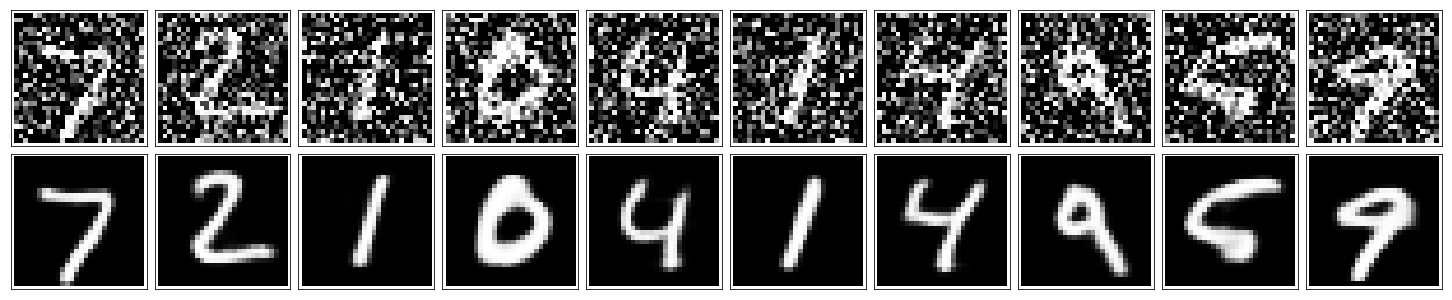

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

## Plot Residuals and Principal Component

We now need to determine how well this autoencoder works. For each image in the MNIST test dataset, compute the residual error of the autoencoder. This is the difference between the true image and the reconstruction of that image by the autoencoder. It is an image itself. Prepare a figure showing the mean residual error, and the first five principal components. Each is an image. You should preserve signs (i.e. the mean residual error may have negative as well as positive entries). The way to show these images most informatively is to use a mid gray value for zero, then darker values for more negative image values and lighter values for more positive values.

In [219]:
in_imgs = mnist.test.images

#Calculate residual mean of auto-encoded images
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((-1, 28, 28, 1))}).reshape(-1, 28, 28)
ae_mean_residual = np.mean(np.subtract(in_imgs.reshape(-1, 28, 28), reconstructed), axis=0)

#Get first 5 principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(in_imgs)
pc = pca.components_

images = np.concatenate((ae_mean_residual.reshape(-1, 28, 28), pc.reshape(-1, 28, 28)))

Plot mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively and

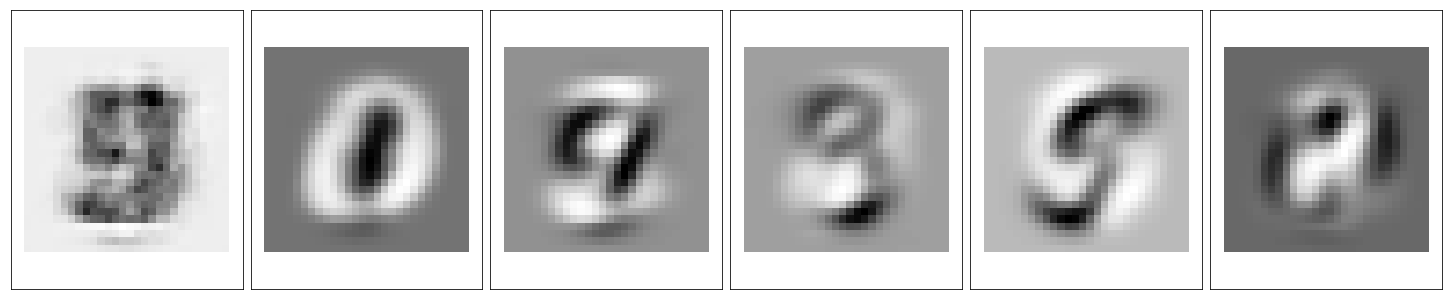

In [220]:
def show_images(imgs):
    fig, axes = plt.subplots(nrows=1, ncols=imgs.shape[0], sharex=True, sharey=True, figsize=(20,4))
    for img, ax in zip(imgs, axes):
        ax.imshow(img, cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)

#Normailze with global value
image_1 = np.copy(images)
max_val = np.max(images1)
min_val = np.min(images1)

images1 = (image_1 - min_val) / (max_val - min_val)

show_images(images1)

Plot mean and five principal components on a scale where the gray scale is chosen for each image separately.

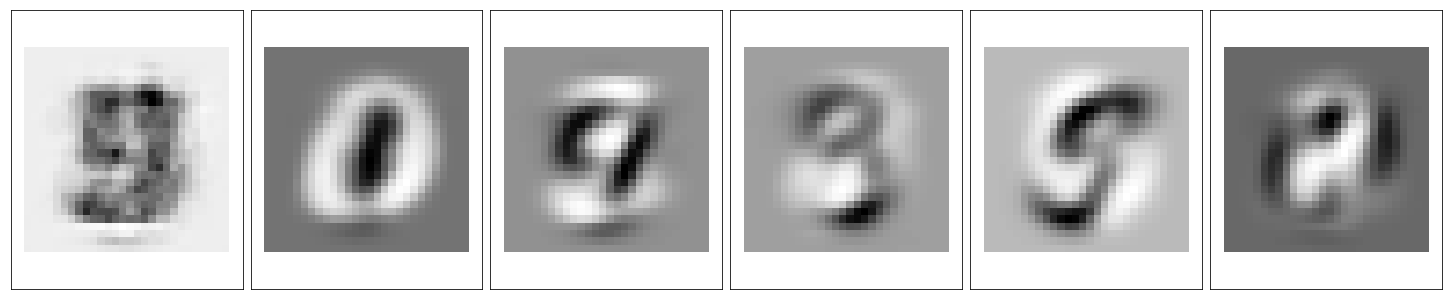

In [221]:
#Normailze with each image
images2 = np.copy(images)

for i in range(6):
    max_val = np.max(images[i])
    min_val = np.min(images[i])

    images2[i,] = (images2[i,] - min_val) / (max_val - min_val)

show_images(images2)

# Variational autoencoders

We will evaluate variational autoencoders applied to the MNIST dataset.

The VAE code is downloaded from 

* https://github.com/hwalsuklee/tensorflow-mnist-VAE

We now need to determine how well the codes produced by this autoencoder can be interpolated.
* For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.
* For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

## Build Model

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import vae
from tensorflow.examples.tutorials.mnist import input_data

dim_z = 20
n_hidden = 500
learn_rate = 1e-3
dim_img = mnist.train.images.shape[1]

x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

# network architecture
y, z, loss, neg_marginal_likelihood, KL_divergence = vae.autoencoder(x, x, dim_img, dim_z, n_hidden, keep_prob)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)

decoded = vae.decoder(z_in, dim_img, n_hidden)

## Training

We will train the model and regenerate the images as asked.

In [48]:
batch_size = 128
num_epochs = 20
batch_size = 128
total_batch = mnist.train.images.shape[0]//batch_size

def split_codes(codes, interval_num):
    results = np.zeros((interval_num + 2, codes.shape[1]))
    results[0] = codes[0]
    results[interval_num + 1] = codes[1]
        
    interval = (codes[1] - codes[0]) / (interval_num + 1)
    diff = np.copy(interval)
        
    for i in range(1, interval_num + 1):
        results[i] = codes[0] + diff
        diff += interval
        
    return results

#Prepare digit images for testing
SameDigitPairs = mnist.train.images[np.argwhere(mnist.train.labels == 2)[100:120]].reshape(-1, dim_img)
DiffDigitParis = np.zeros((20, dim_img))
for i in range(10):
    images = mnist.train.images[np.argwhere(mnist.train.labels == i)[200:202]].reshape(-1, dim_img)

    DiffDigitParis[i * 2, :] = images[0]
    DiffDigitParis[i * 2 + 1, :] = images[1]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})
    for epoch in range(num_epochs):
        for i in range(total_batch):
            train_images, train_labels = mnist.train.next_batch(batch_size)
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                    (train_op, loss, neg_marginal_likelihood, KL_divergence),
                    feed_dict={x: train_images, keep_prob : 0.9})
            
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))
    
    
    same_z_codes = sess.run((z), feed_dict={x: SameDigitPairs, keep_prob : 1}).reshape(10, 2, -1)
    diff_z_codes = sess.run((z), feed_dict={x: DiffDigitParis, keep_prob : 1}).reshape(10, 2, -1)

    same_z_codes = np.array([split_codes(codes, 7) for codes in same_z_codes])
    diff_z_codes = np.array([split_codes(codes, 7) for codes in diff_z_codes])
    
    same_images = sess.run(decoded, feed_dict={z_in: same_z_codes.reshape(-1, dim_z), keep_prob : 1})
    diff_images = sess.run(decoded, feed_dict={z_in: diff_z_codes.reshape(-1, dim_z), keep_prob : 1})

epoch 0: L_tot 139.35 L_likelihood 114.38 L_divergence 24.98
epoch 1: L_tot 129.99 L_likelihood 105.07 L_divergence 24.92
epoch 2: L_tot 122.08 L_likelihood 96.94 L_divergence 25.15
epoch 3: L_tot 118.56 L_likelihood 94.22 L_divergence 24.34
epoch 4: L_tot 114.67 L_likelihood 90.78 L_divergence 23.89
epoch 5: L_tot 111.75 L_likelihood 87.80 L_divergence 23.95
epoch 6: L_tot 108.68 L_likelihood 84.83 L_divergence 23.84
epoch 7: L_tot 109.99 L_likelihood 86.38 L_divergence 23.61
epoch 8: L_tot 112.67 L_likelihood 88.02 L_divergence 24.66
epoch 9: L_tot 114.14 L_likelihood 89.51 L_divergence 24.63
epoch 10: L_tot 113.33 L_likelihood 89.51 L_divergence 23.82
epoch 11: L_tot 113.17 L_likelihood 89.63 L_divergence 23.54
epoch 12: L_tot 110.83 L_likelihood 86.22 L_divergence 24.61
epoch 13: L_tot 111.64 L_likelihood 87.44 L_divergence 24.19
epoch 14: L_tot 112.49 L_likelihood 88.40 L_divergence 24.09
epoch 15: L_tot 114.32 L_likelihood 90.26 L_divergence 24.06
epoch 16: L_tot 108.74 L_likelih

## Plot Images

We plot the results as below

In [54]:
def plot_image(images):
    fig, axes = plt.subplots(nrows=10, ncols=9, sharex=True, sharey=True, figsize=(20,20))

    for row_imgs, row in zip(images, axes):
        for img, ax in zip(row_imgs, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    fig.tight_layout(pad=0.1)

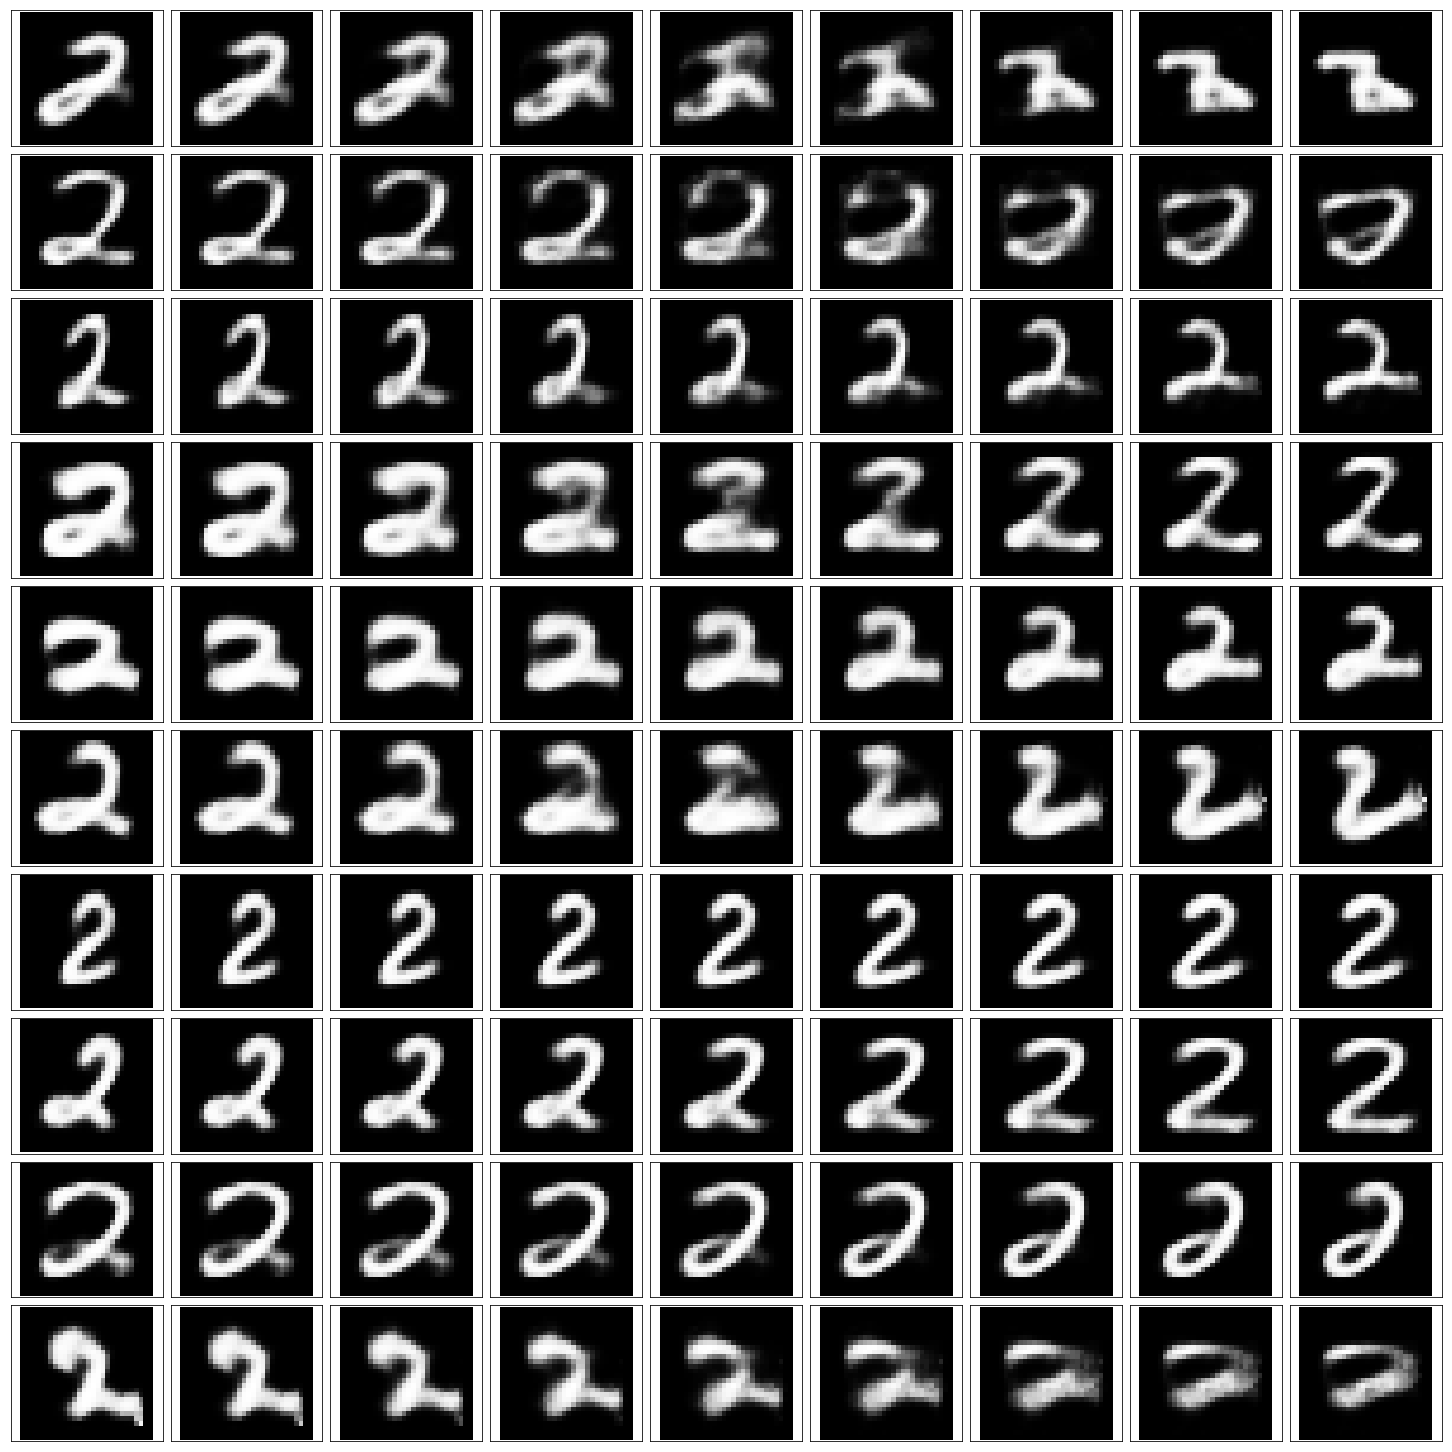

In [55]:
plot_image(same_images.reshape(10,9,-1))

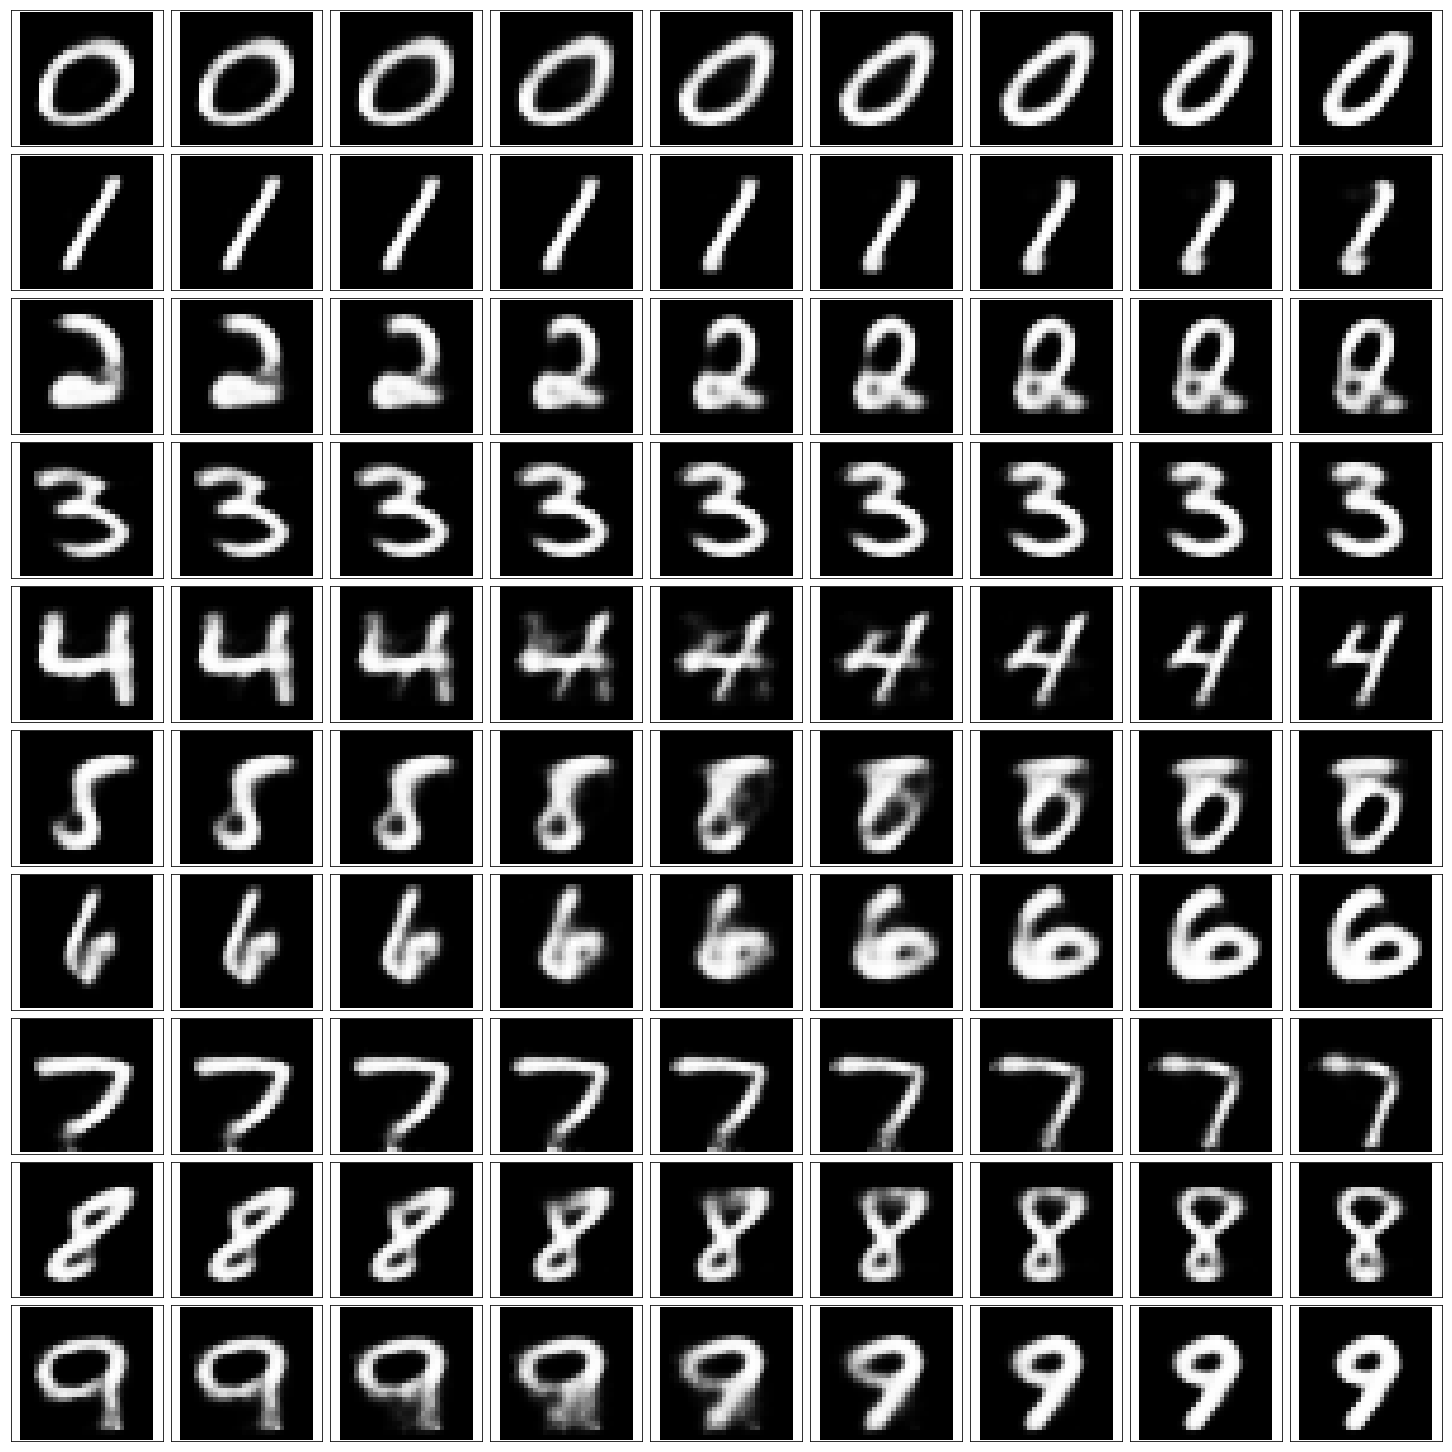

In [56]:
plot_image(diff_images.reshape(10,9,-1))